# Задачи:
1. Проанализировать данные, построить гипотезы, проверить взаимосвязи между показателями;
2. Построить модели для тех рядов, которые можно объеденить по времени. Модели сравнивать по метрикам R2, MAE, MAPE;
3. Сделать предсказание на 3 года вперед.

# Импорт библиотек

In [1]:
import pandas as pd

import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Первичный анализ

Забегая вперед замечу:<br>
Для дальнейшего объединения таблиц проведём форматирование наименований видов экономической деятельности. Уберем "из неё/него/них" и "в том числе" которые встречаются в некоторых наименованиях, заменим все союзы "и" на запятые, и сделаем так, чтобы каждое наименование начиналось с заглавной буквы (для эстетики).

Предположим, такое форматирование позволит объединить по времени те наименования, что остались прежними при смене формы отчетности. Наименования, которые нельзя соединить таким способом тоже можно объединить, но это более кропотливый процесс для которого нужна консультация человека составившего отчет.

In [2]:
def clean_columns(columns):
    
    """
    Функция для очистки названия колонок.
    Убирает 'из неё/него/них' и 'в том числе' из начала названий.
    Заменяет союзы 'и' на запятые.
    Озаглавливает каждое название.
    """

    new_columns = []
    for column in columns.str.split():
        if column[0] == 'из': column = column[2:]
        elif column[0] == 'в': column = column[3:]
        # Убираем "из него/неё/них" и "в том числе"
        while True:
            try:
                column[column.index('и') - 1] += ','
                del column[column.index('и')]
            except:
                break
        # Заменяем "и" на запятые
        new_columns.append(column)
    return pd.Index(new_columns).str.join(' ').str.capitalize()

## 2005-2016 год

Рассмотрим данные за 2005-2016 годы.

In [3]:
df_05_16 = pd.read_excel('oborot-mes.xls', sheet_name='1', header=4, index_col=0, skipfooter=2)
df_05_16 = df_05_16.transpose()
df_05_16.index = pd.date_range(start='2005-01-01', end='2016-12-31', freq='M')
df_05_16.columns = clean_columns(df_05_16.columns)
df_05_16.head()

Всего  Селькое хозяйство, охота, лесное хозяйство  \
2005-01-31  2301.729050                                   30.994254   
2005-02-28  2462.974248                                   34.385567   
2005-03-31  2750.346042                                   41.044655   
2005-04-30  2782.331959                                   42.393740   
2005-05-31  2740.964989                                   41.577752   

            Рыболовство, рыбоводство  Добыча полезных ископаемых  \
2005-01-31                  2.291198                  186.835122   
2005-02-28                  3.058128                  199.912625   
2005-03-31                  6.284073                  236.289637   
2005-04-30                  6.654814                  243.632127   
2005-05-31                  3.882850                  257.886772   

            Добыча топливно-энергетических полезных ископаемых  \
2005-01-31                                         160.221580    
2005-02-28                                         171.282185    
2005-03-31                                         202.917407    
2005-04-30                                         212.517417    
2005-05-31                                         224.462264    

            Добыча полезных ископаемых, кроме топливно-энергетических  \
2005-01-31                                          26.613543           
2005-02-28                                          28.630439           
2005-03-31                                          33.372230           
2005-04-30                                          31.114709           
2005-05-31                                          33.424508           

            Обрабатывающие производства  \
2005-01-31                   570.891874   
2005-02-28                   627.645222   
2005-03-31                   733.506945   
2005-04-30                   753.582793   
2005-05-31                   764.955103   

            Производство пищевых продуктов, включая напитки,, табака  \
2005-01-31                                          84.875837          
2005-02-28                                          92.879075          
2005-03-31                                         111.572821          
2005-04-30                                         114.287188          
2005-05-31                                         115.078333          

            Текстильное производство  \
2005-01-31                  6.149034   
2005-02-28                  7.844342   
2005-03-31                  9.242008   
2005-04-30                  9.047439   
2005-05-31                  8.583037   

            Производство кожи, изделий из кожи, производство обуви  ...  \
2005-01-31                                           1.368235       ...   
2005-02-28                                           1.657100       ...   
2005-03-31                                           1.951120       ...   
2005-04-30                                           1.951037       ...   
2005-05-31                                           1.785587       ...   

            Транспортирование по трубопроводам  \
2005-01-31                           38.143250   
2005-02-28                           44.902079   
2005-03-31                           53.539547   
2005-04-30                           68.376604   
2005-05-31                           60.954633   

            Деятельность водного трансопрта  \
2005-01-31                         4.207542   
2005-02-28                         3.202046   
2005-03-31                         4.044241   
2005-04-30                         4.286686   
2005-05-31                         6.103718   

            Деятельность воздушного, космического транспорта      Связь  \
2005-01-31                                         11.096877  56.212934   
2005-02-28                                         10.891516  49.996809   
2005-03-31                                         12.932111  54.022142   
2005-04-30                                         13.851975  55.680493   
200

Обзор таблицы методами `info()` и `describe()` неинформативен. Так как пропусков в таблице нет, а резултат `describe()` слишком массивен для воспиятия и не несет критически важной информации.

По структуре таблицы (просмотренной еще в экселе) видно, что часть наименований являются наименованиями групп в которые включены другие наименования поменьше. В свою очередь крупные наименования в сумме дают графу **"Всего"**. Таким образом, раз основным принципом таблицы является суммирование показателей с меньших подгрупп в большие, значит между каждой подруппой и соответствующей её группой должна быть прямая линейная зависимость. 

Что касается несвязанных групп: между ними прямая зависимость необязательна. Но поскольку бизнес, если он успешен, имеет тенденцию к росту оброта со временем, то можно предположить, что даже не связанные по типу подгруппа-группа наименования будут иметь слабую прямую линейную зависимость.

Косвенным показателем стабильности роста оборота определенного направления можно считать коэффициент корреляции между проверяемым направлением и графой **Всего**. Если в каком-то из паравлений оборот растет "скачкообразно" относительно общего оборота, то коэффициент корреляции будет ниже.

---

Для проверки наличия прямой зависимости между параметрами построим матрицу диаграмм рассеяния и хитмэп коэффициентов корреляции (Пирсон).

Так как матрица диаграмм рассеяния становится трудноинтерпритурема при большом количестве категорий, построим матрицу только для первых 10 и проверим верность предположений.

<Figure size 1440x1440 with 0 Axes>

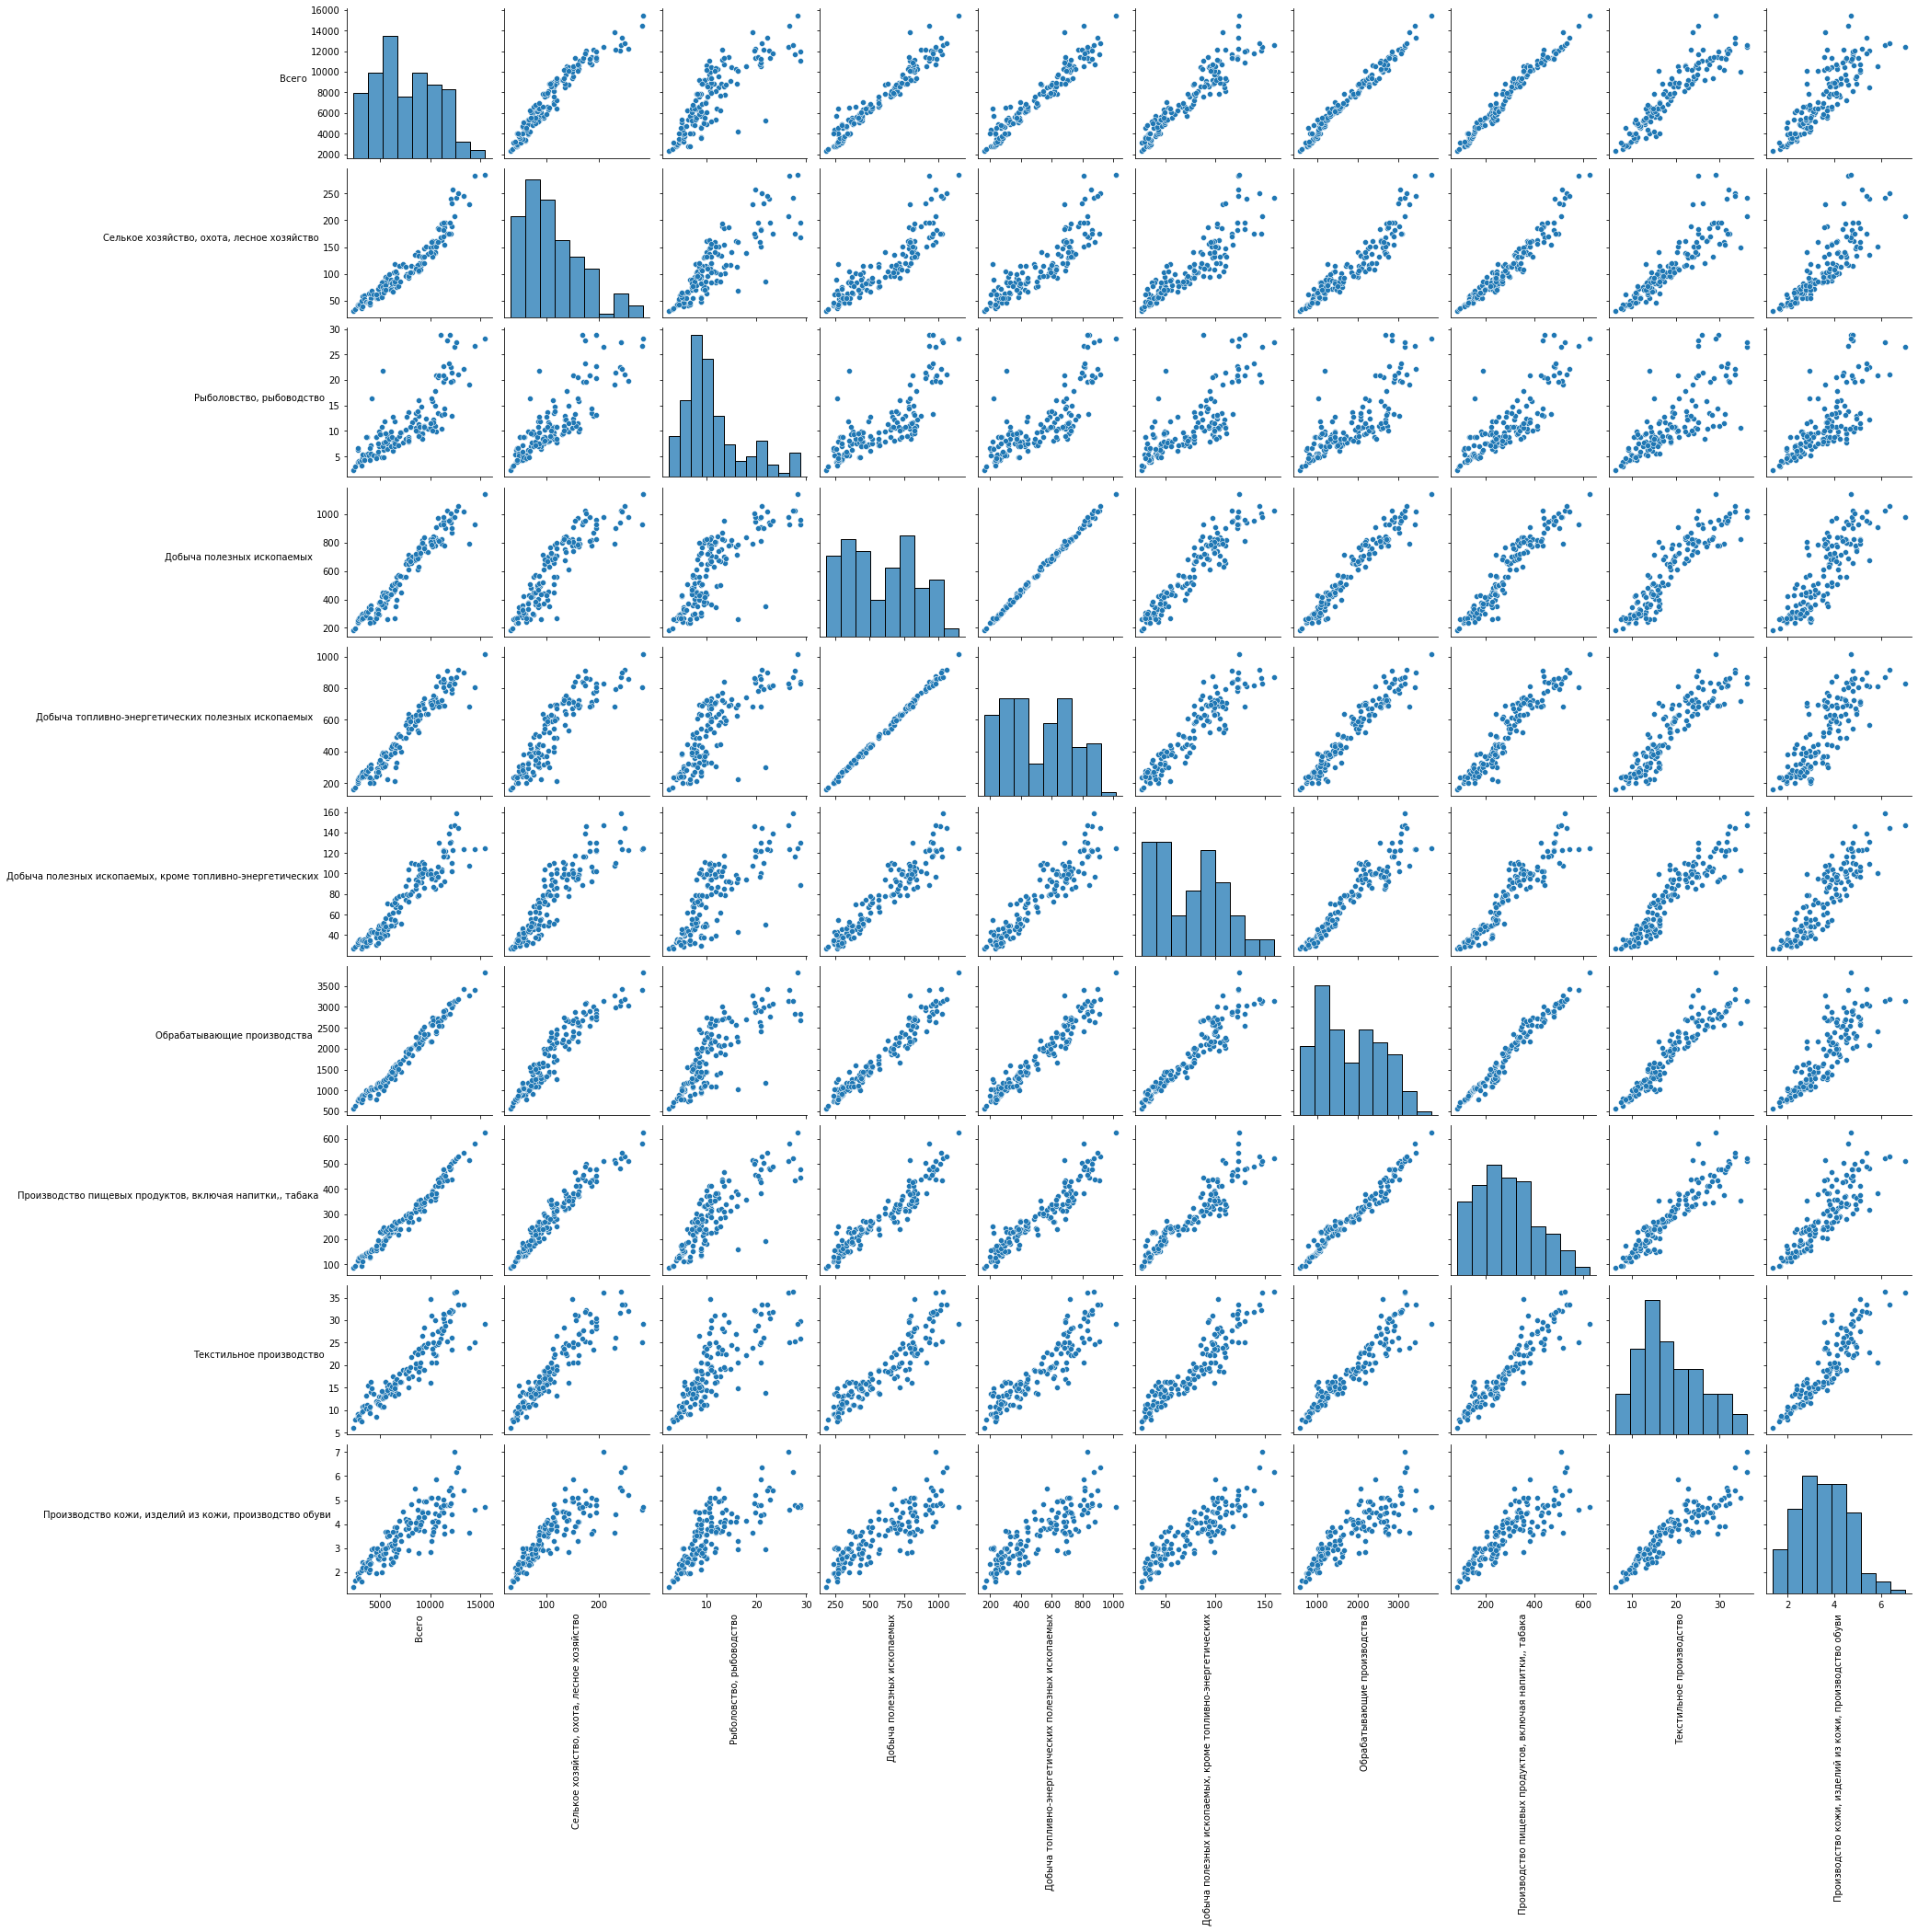

In [4]:
plt.figure(figsize=(20, 20))
g = sns.pairplot(df_05_16.iloc[:,0:10])
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    ax.yaxis.get_label().set_horizontalalignment('right')
plt.show()

Видно, что между всеми отображенными категориями прослеживается прямая линейная зависимость разной силы. На данном графике особенно хорошо видна линейная зависимость между добычей полезных ископаемых и добычей топливно-энергетических полезных ископаемых. Что вполне логично, так как добыча топливно-энергетических полезных ископаемых является значительной составной частью от общей добычи полезных ископаемых.

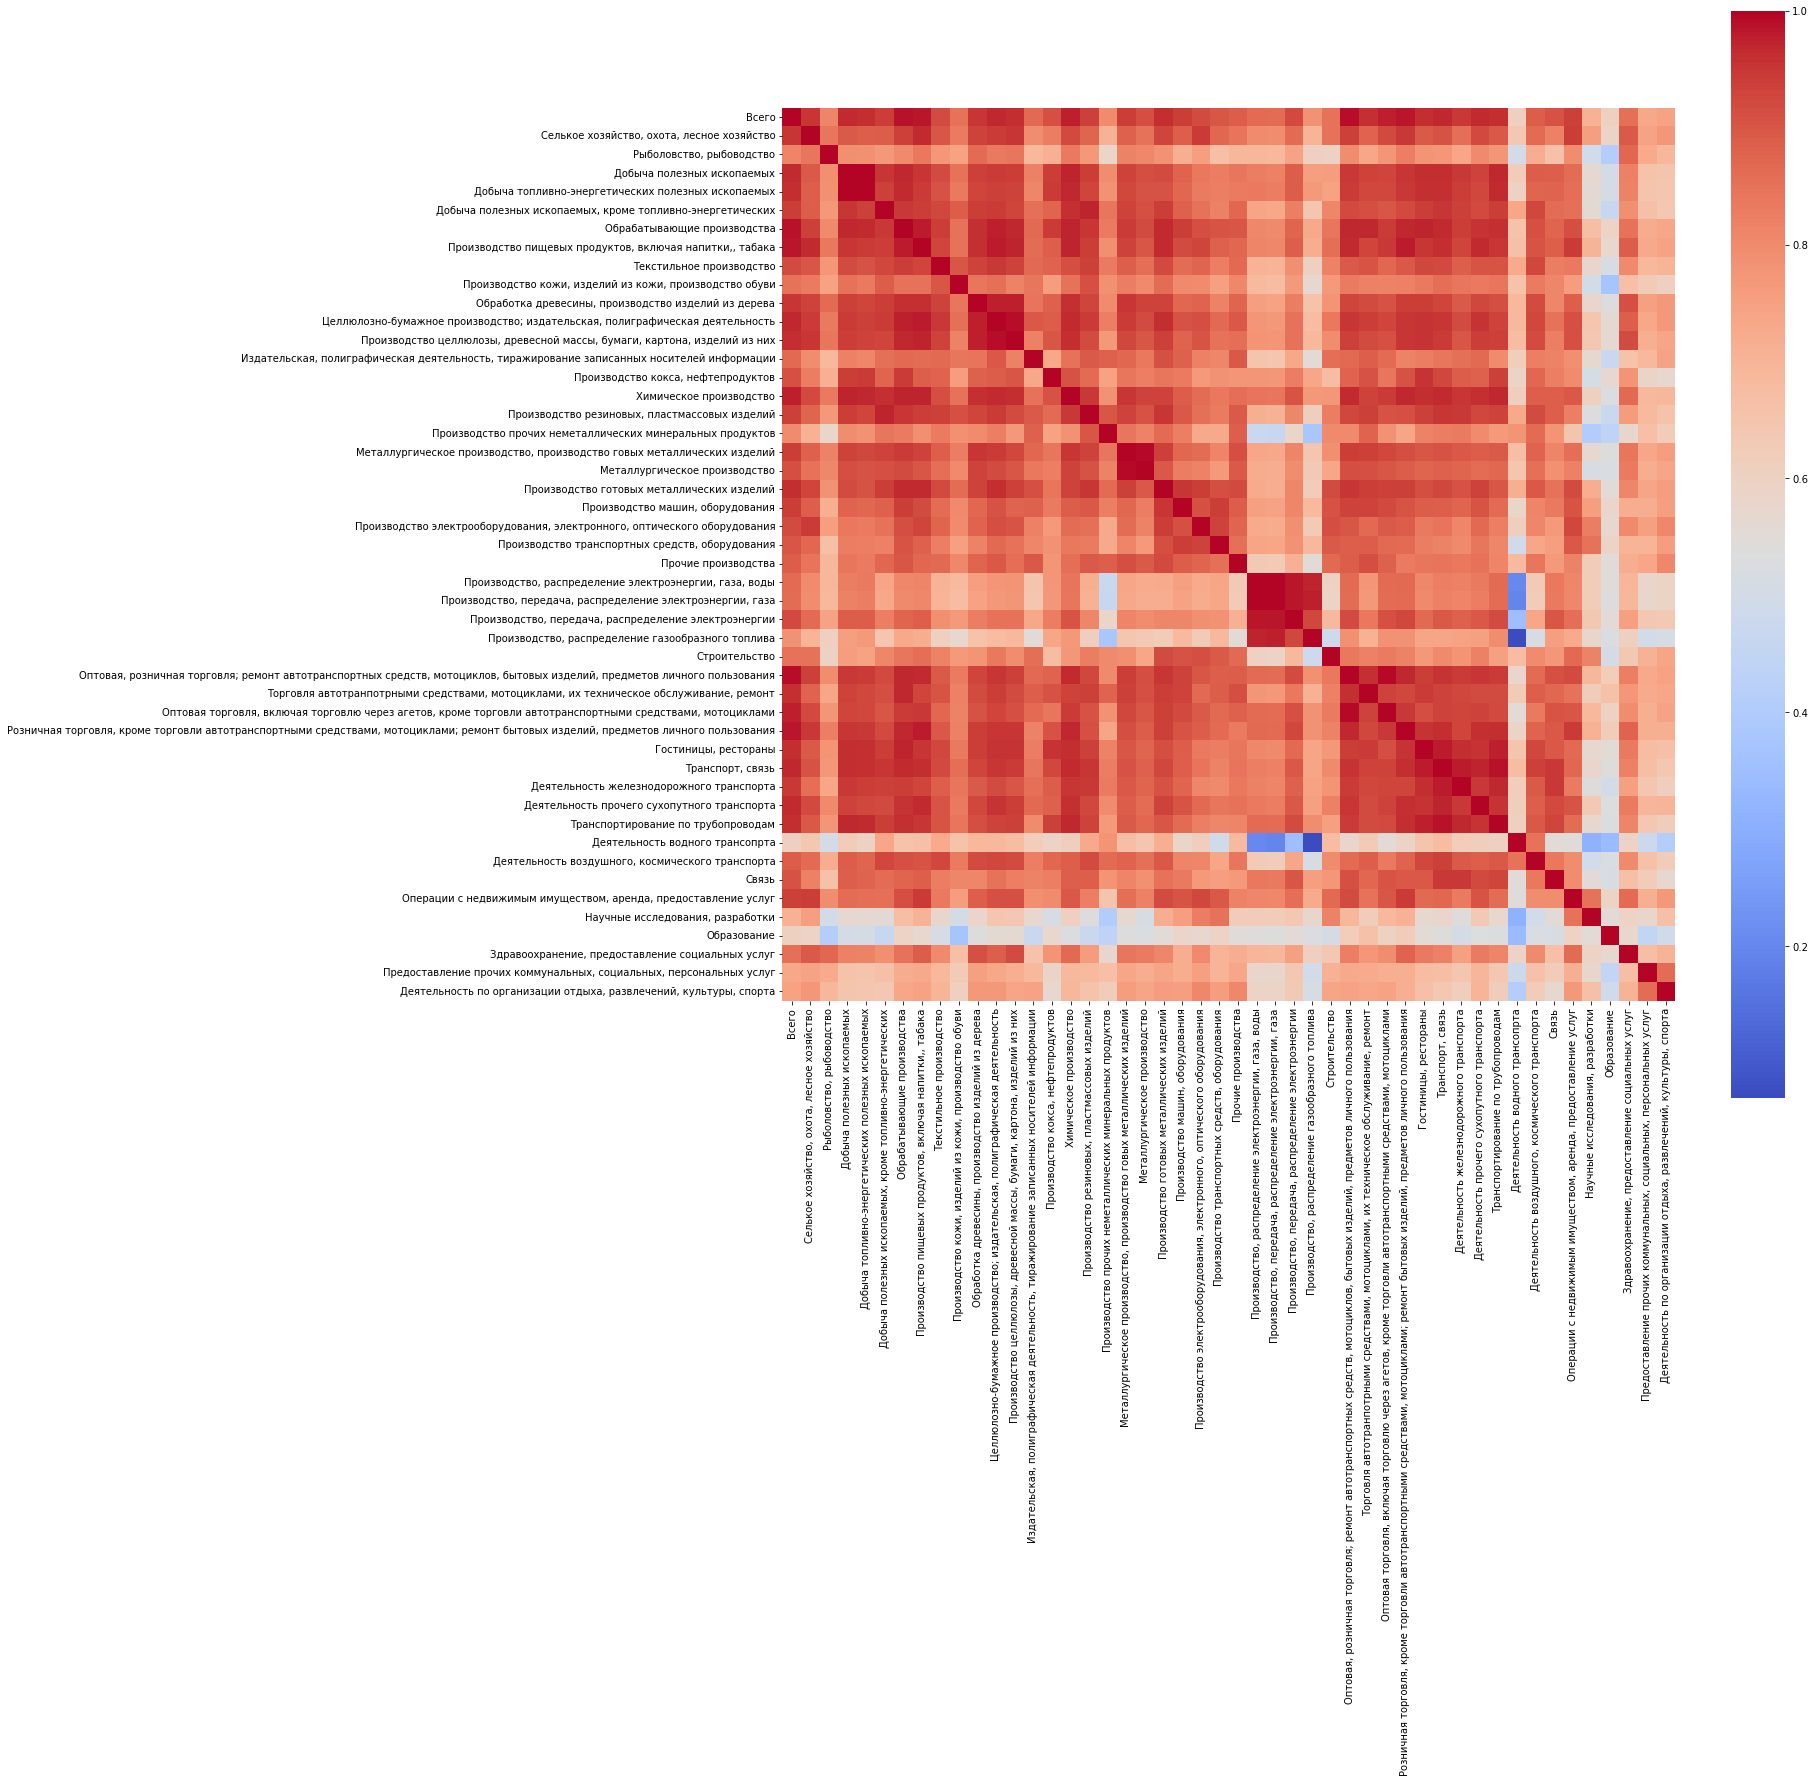

In [5]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_05_16.corr(), cmap='coolwarm', square=True)
plt.show()

Большинство корреляций свидетельствуют о явной линейной зависимости между параметрами. Поближе посмотрим на те, что выбиваются из большинства.

<Figure size 1440x1440 with 0 Axes>

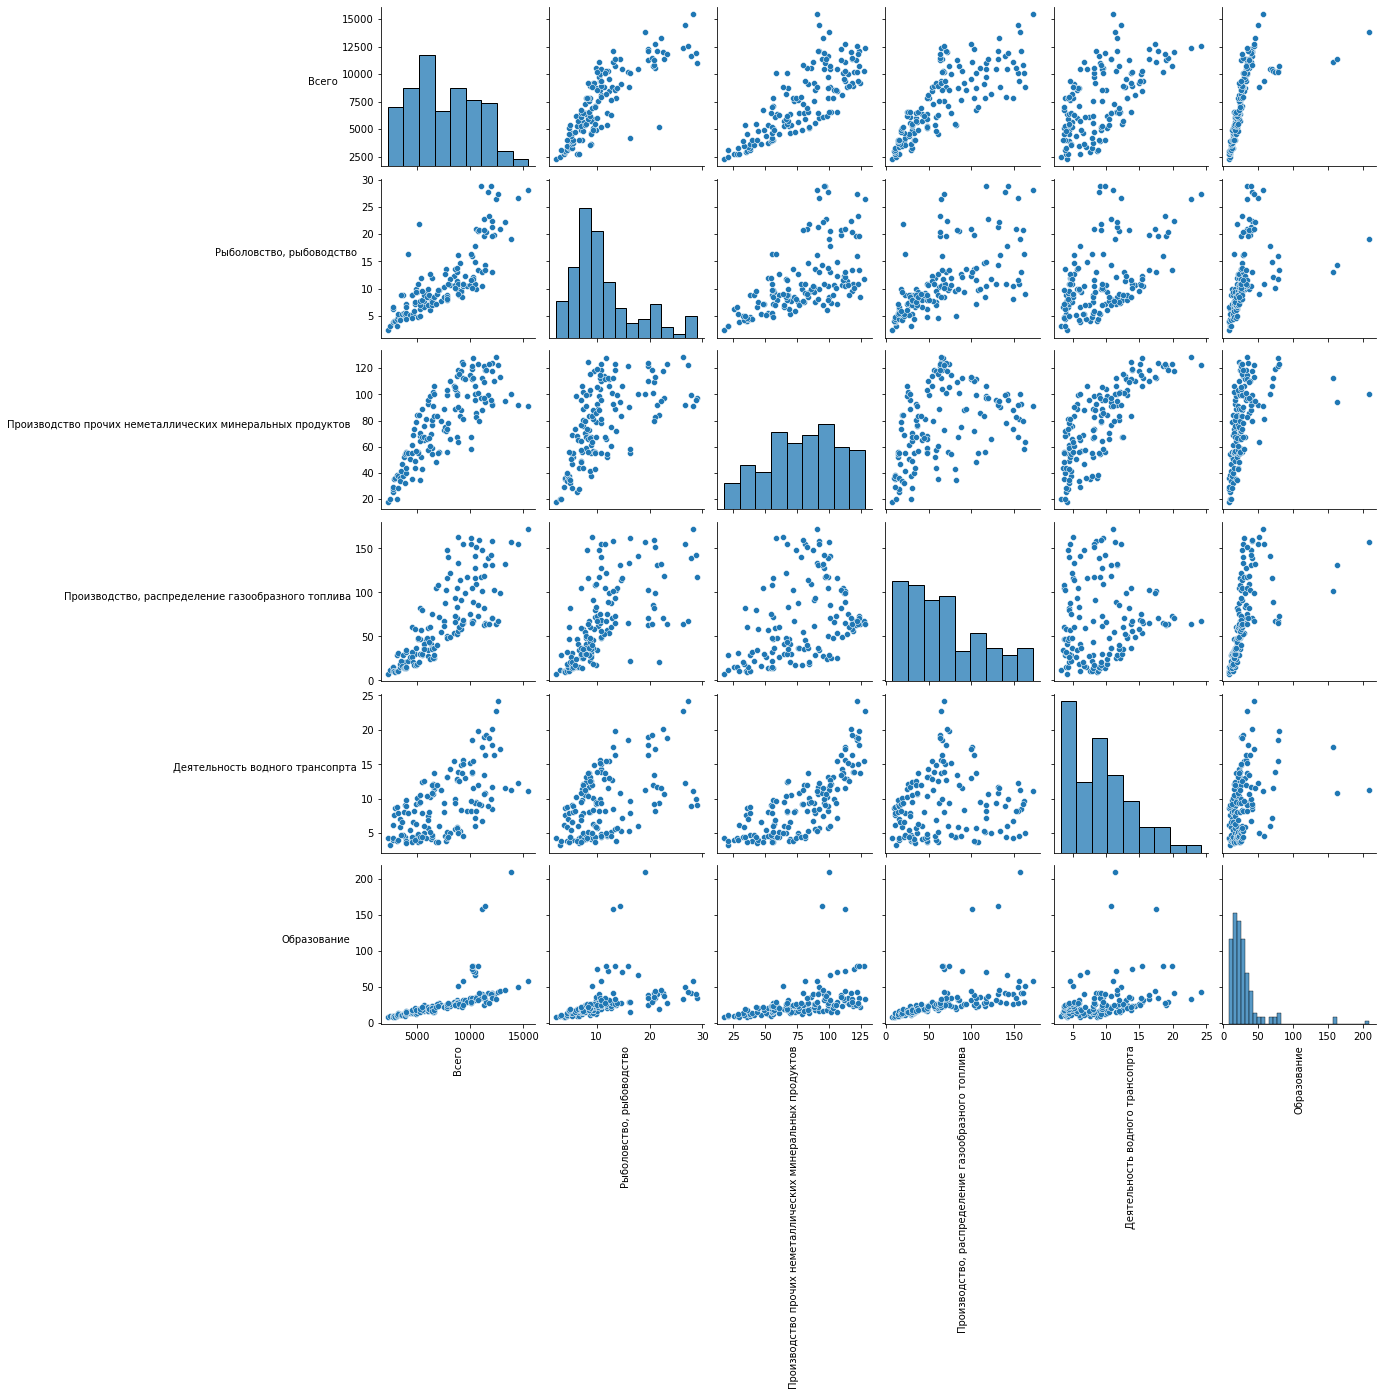

In [6]:
plt.figure(figsize=(20, 20))
g = sns.pairplot(
    df_05_16.loc[:,['Всего',
                    'Рыболовство, рыбоводство',
                    'Производство прочих неметаллических минеральных продуктов',
                    'Производство, распределение газообразного топлива',
                    'Деятельность водного трансопрта',
                    'Образование']])
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    ax.yaxis.get_label().set_horizontalalignment('right')
plt.show()

Они выглядят как и ожидалось, как распределяния со слабой линейной зависимостью. Однако **"Образование"** выглядит особенно интересно. Видно, что зависмость между **"Всего"** и **"Образование"**  имеет хорошо выраженный линейный характер, но не распознается как таковой из-за наличия нескольких выбросов неожиданно больших значений в обороте для образования. Без данных выбросов они бы имели явную прямую линейную зависимость.

Раскладывать временные ряды для всех 48 наименований (а в следующей таблице 71го) с последующим анализом каждого задача крайне объемная. Поэтому, при условии что строить прогноз придется только для тех наименований которые сойдутся в обеих таблицах, более разумным подходом было бы разложить ряды именно для них.

## 2017-2022 год

Проведем аналогичный обзор для второй таблицы.

In [7]:
df_17_22 = pd.read_excel('oborot-mes.xls', sheet_name='2', header=4, index_col=0, skipfooter=2, usecols='A, C:BP')
df_17_22 = df_17_22.transpose()
df_17_22.index = pd.date_range(start='2017-01-01', end='2022-06-30', freq='M')
df_17_22.columns = clean_columns(df_17_22.columns)
df_17_22.head()

Всего  \
2017-01-31       11044.9   
2017-02-28       10839.3   
2017-03-31  12449.341926   
2017-04-30       11851.1   
2017-05-31       11867.8   

           Сельское, лесное хозяйство, охота, рыболовство, рыбоводство  \
2017-01-31                                              181.2            
2017-02-28                                              195.0            
2017-03-31                                         217.901649            
2017-04-30                                              209.5            
2017-05-31                                              200.6            

           Растениеводство, животноводство, охота, предоставление соответствующих услуг в этих областях  \
2017-01-31                                              142.8                                             
2017-02-28                                              151.5                                             
2017-03-31                                         173.003638                                             
2017-04-30                                              166.6                                             
2017-05-31                                                164                                             

           Лесоводство, лесозаготовки Рыболовство, рыбоводство  \
2017-01-31                       22.7                     15.7   
2017-02-28                       23.2                     20.3   
2017-03-31                  18.513076                26.384935   
2017-04-30                       16.9                     26.0   
2017-05-31                       15.5                     21.1   

           Добыча полезных ископаемых Добыча угля  \
2017-01-31                     1141.0       121.7   
2017-02-28                     1054.8       111.0   
2017-03-31                1105.112171  113.885343   
2017-04-30                     1065.4        98.6   
2017-05-31                     1061.1         103   

           Добыча сырой нефти, природного газа Добыча металлических руд  \
2017-01-31                               786.1                     67.8   
2017-02-28                               705.2                     69.9   
2017-03-31                          712.917003                81.926126   
2017-04-30                               706.9                     82.9   
2017-05-31                               694.4                     81.7   

           Добыча прочих полезных ископаемых  ...  \
2017-01-31                              39.6  ...   
2017-02-28                              43.7  ...   
2017-03-31                         58.449328  ...   
2017-04-30                              42.9  ...   
2017-05-31                              52.8  ...   

           Разработка компьютерного программного обеспечения, консультационные услуги в данной области, другие сопутствующие услуги  \
2017-01-31                                                NaN                                                                         
2017-02-28                                                NaN                                                                         
2017-03-31                                                NaN                                                                         
2017-04-30                                                NaN                                                                         
2017-05-31                                                NaN                                                                         

           Деятельность в области информационных технологий  \
2017-01-31                                             12.7   
2017-02-28                                             12.9   
2017-03-31                                        18.943974   
2017-04-30                                             17.3   
2017-05-31                                             17.2   

           Деятельность по операциям с недвижимым имуществом  \
2017-01-31            

Наличие пропусков в разработке програмного обеспечения обусловлена тем, что его история начинается только с января 2018 г. Зачит пропуски можно заполнить нулями.

In [8]:
df_17_22 = df_17_22.fillna(0)

<Figure size 1440x1440 with 0 Axes>

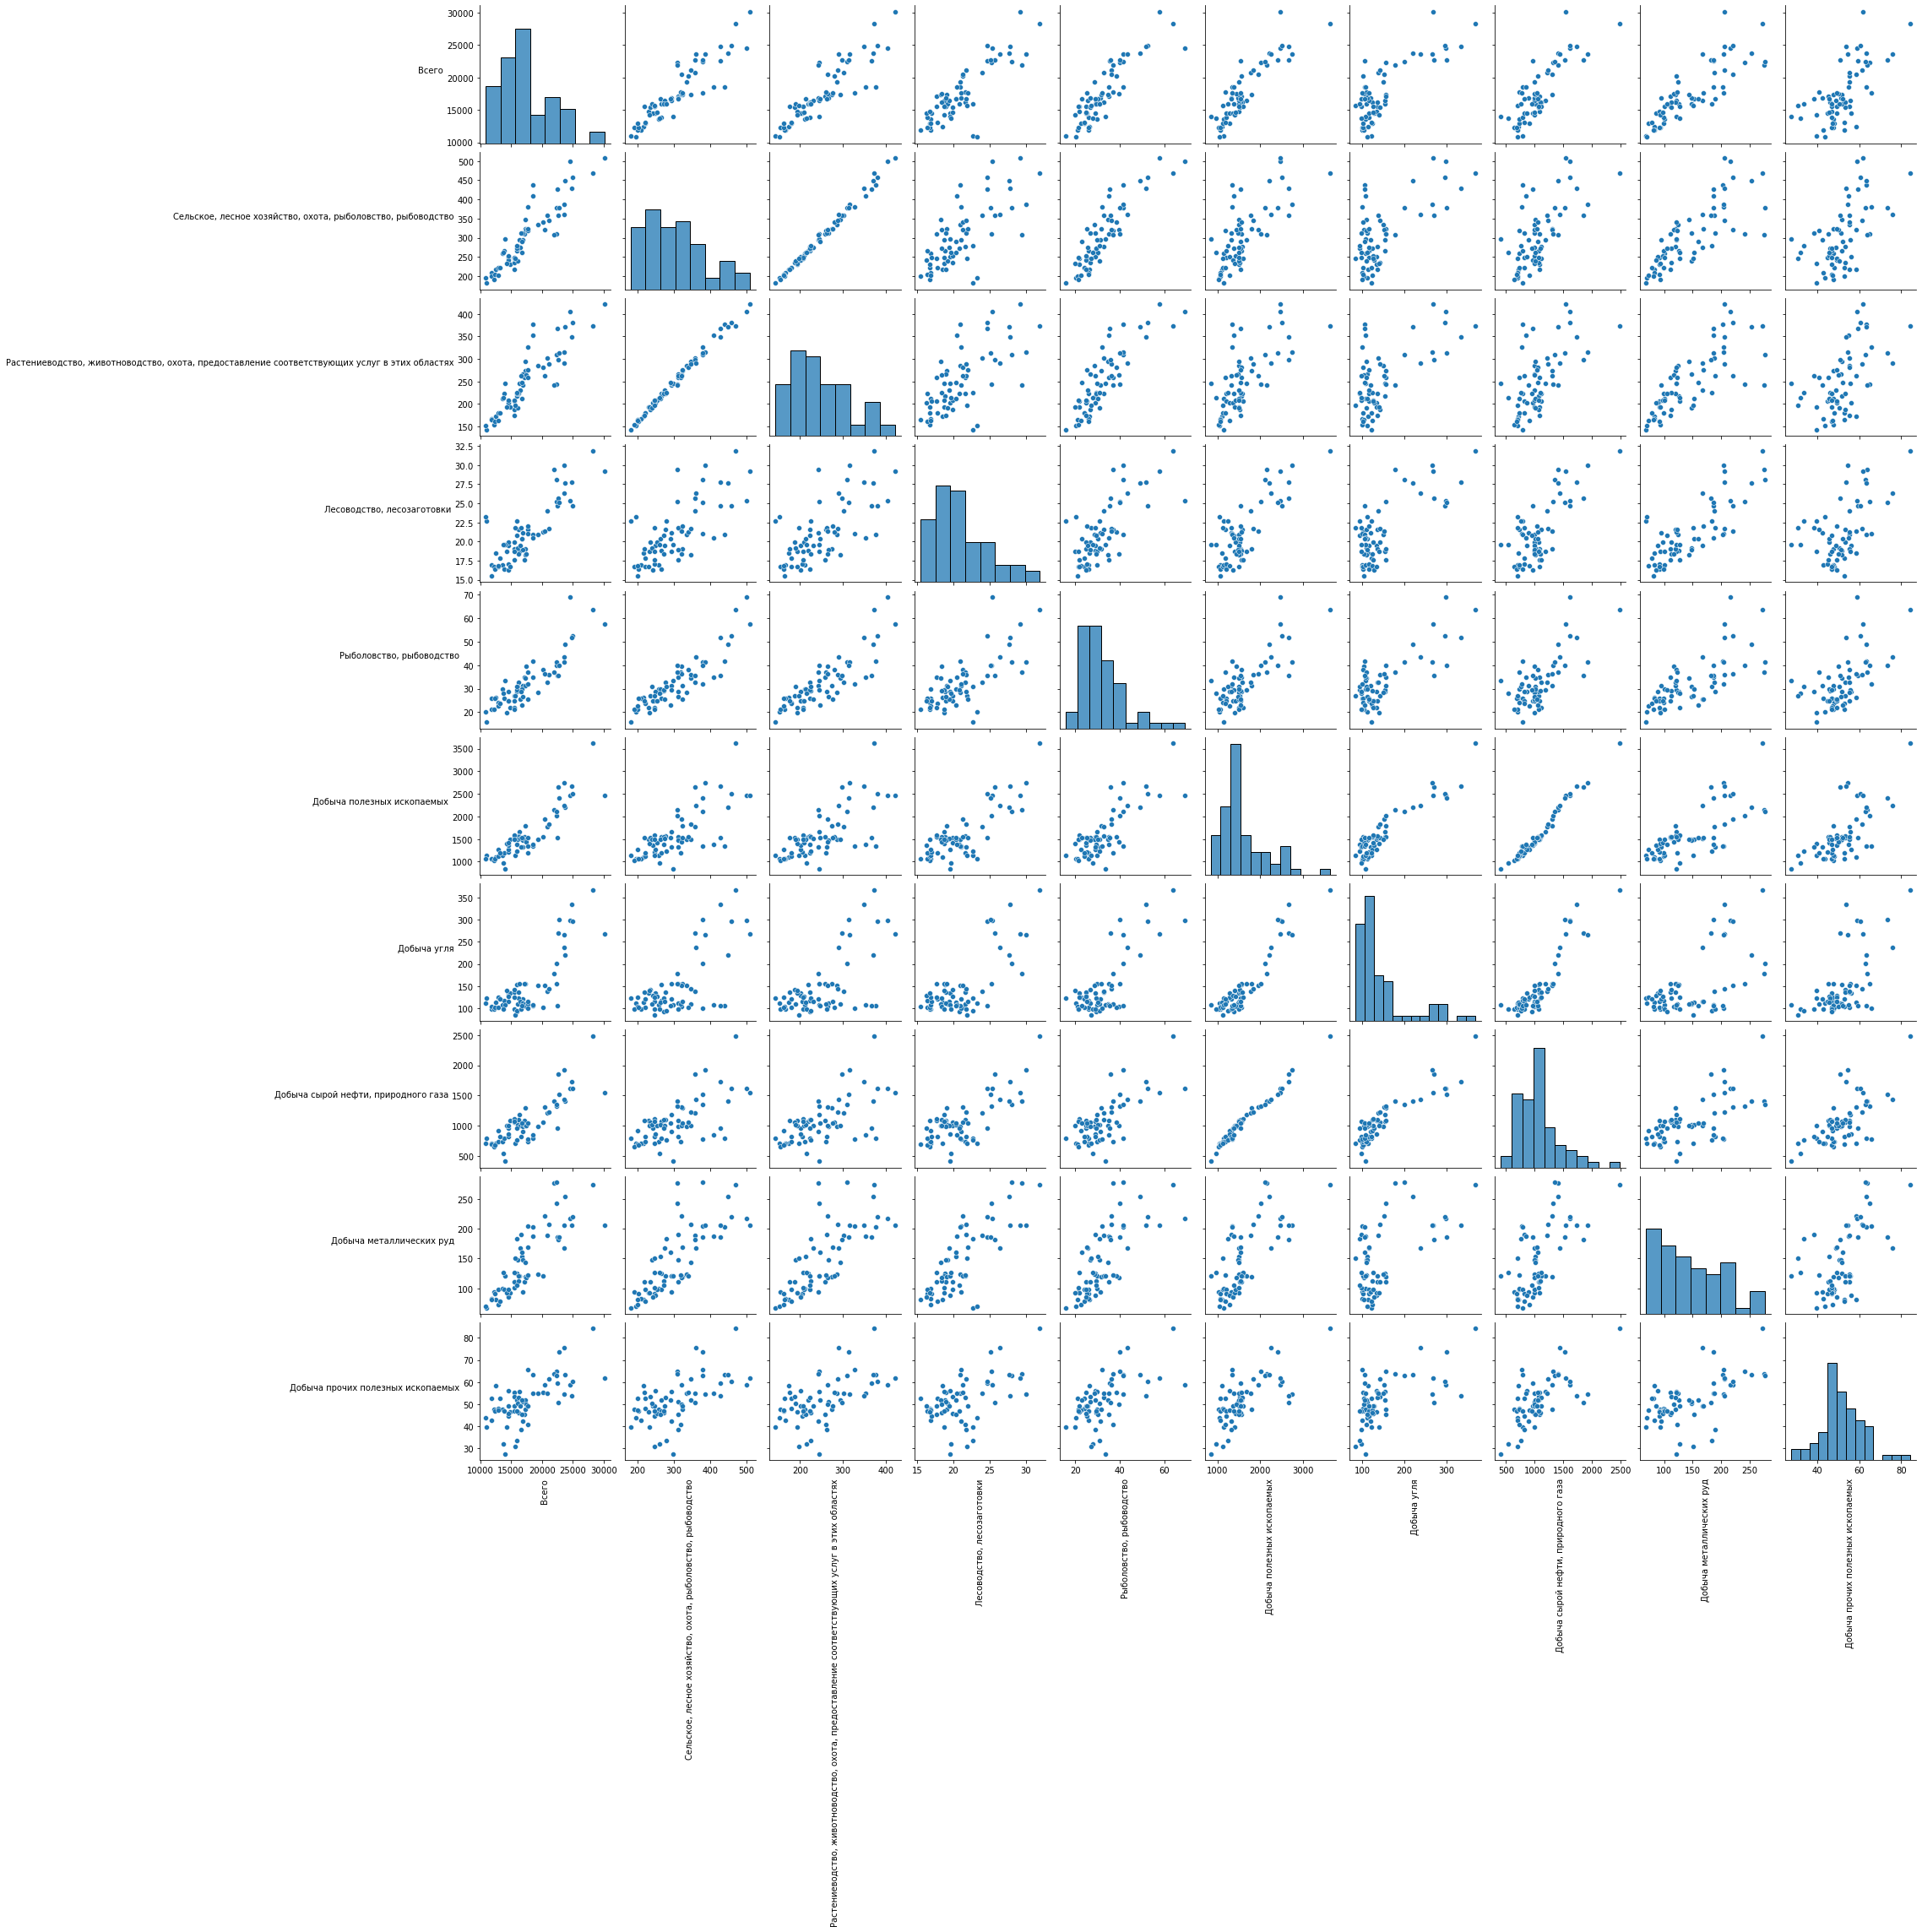

In [9]:
plt.figure(figsize=(20, 20))
g = sns.pairplot(df_17_22.iloc[:,0:10])
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    ax.yaxis.get_label().set_horizontalalignment('right')
plt.show()

Для данной таблицы прямая линейная зависимость мужду наименованиями менее очевидна. Возможно, это связанно с тем, что: 1. Измерений меньше чем в первой таблице; 2. Возросло количество наименований, а значит влияние каждого конкретного наименования на общую сумму стало менее значительным.

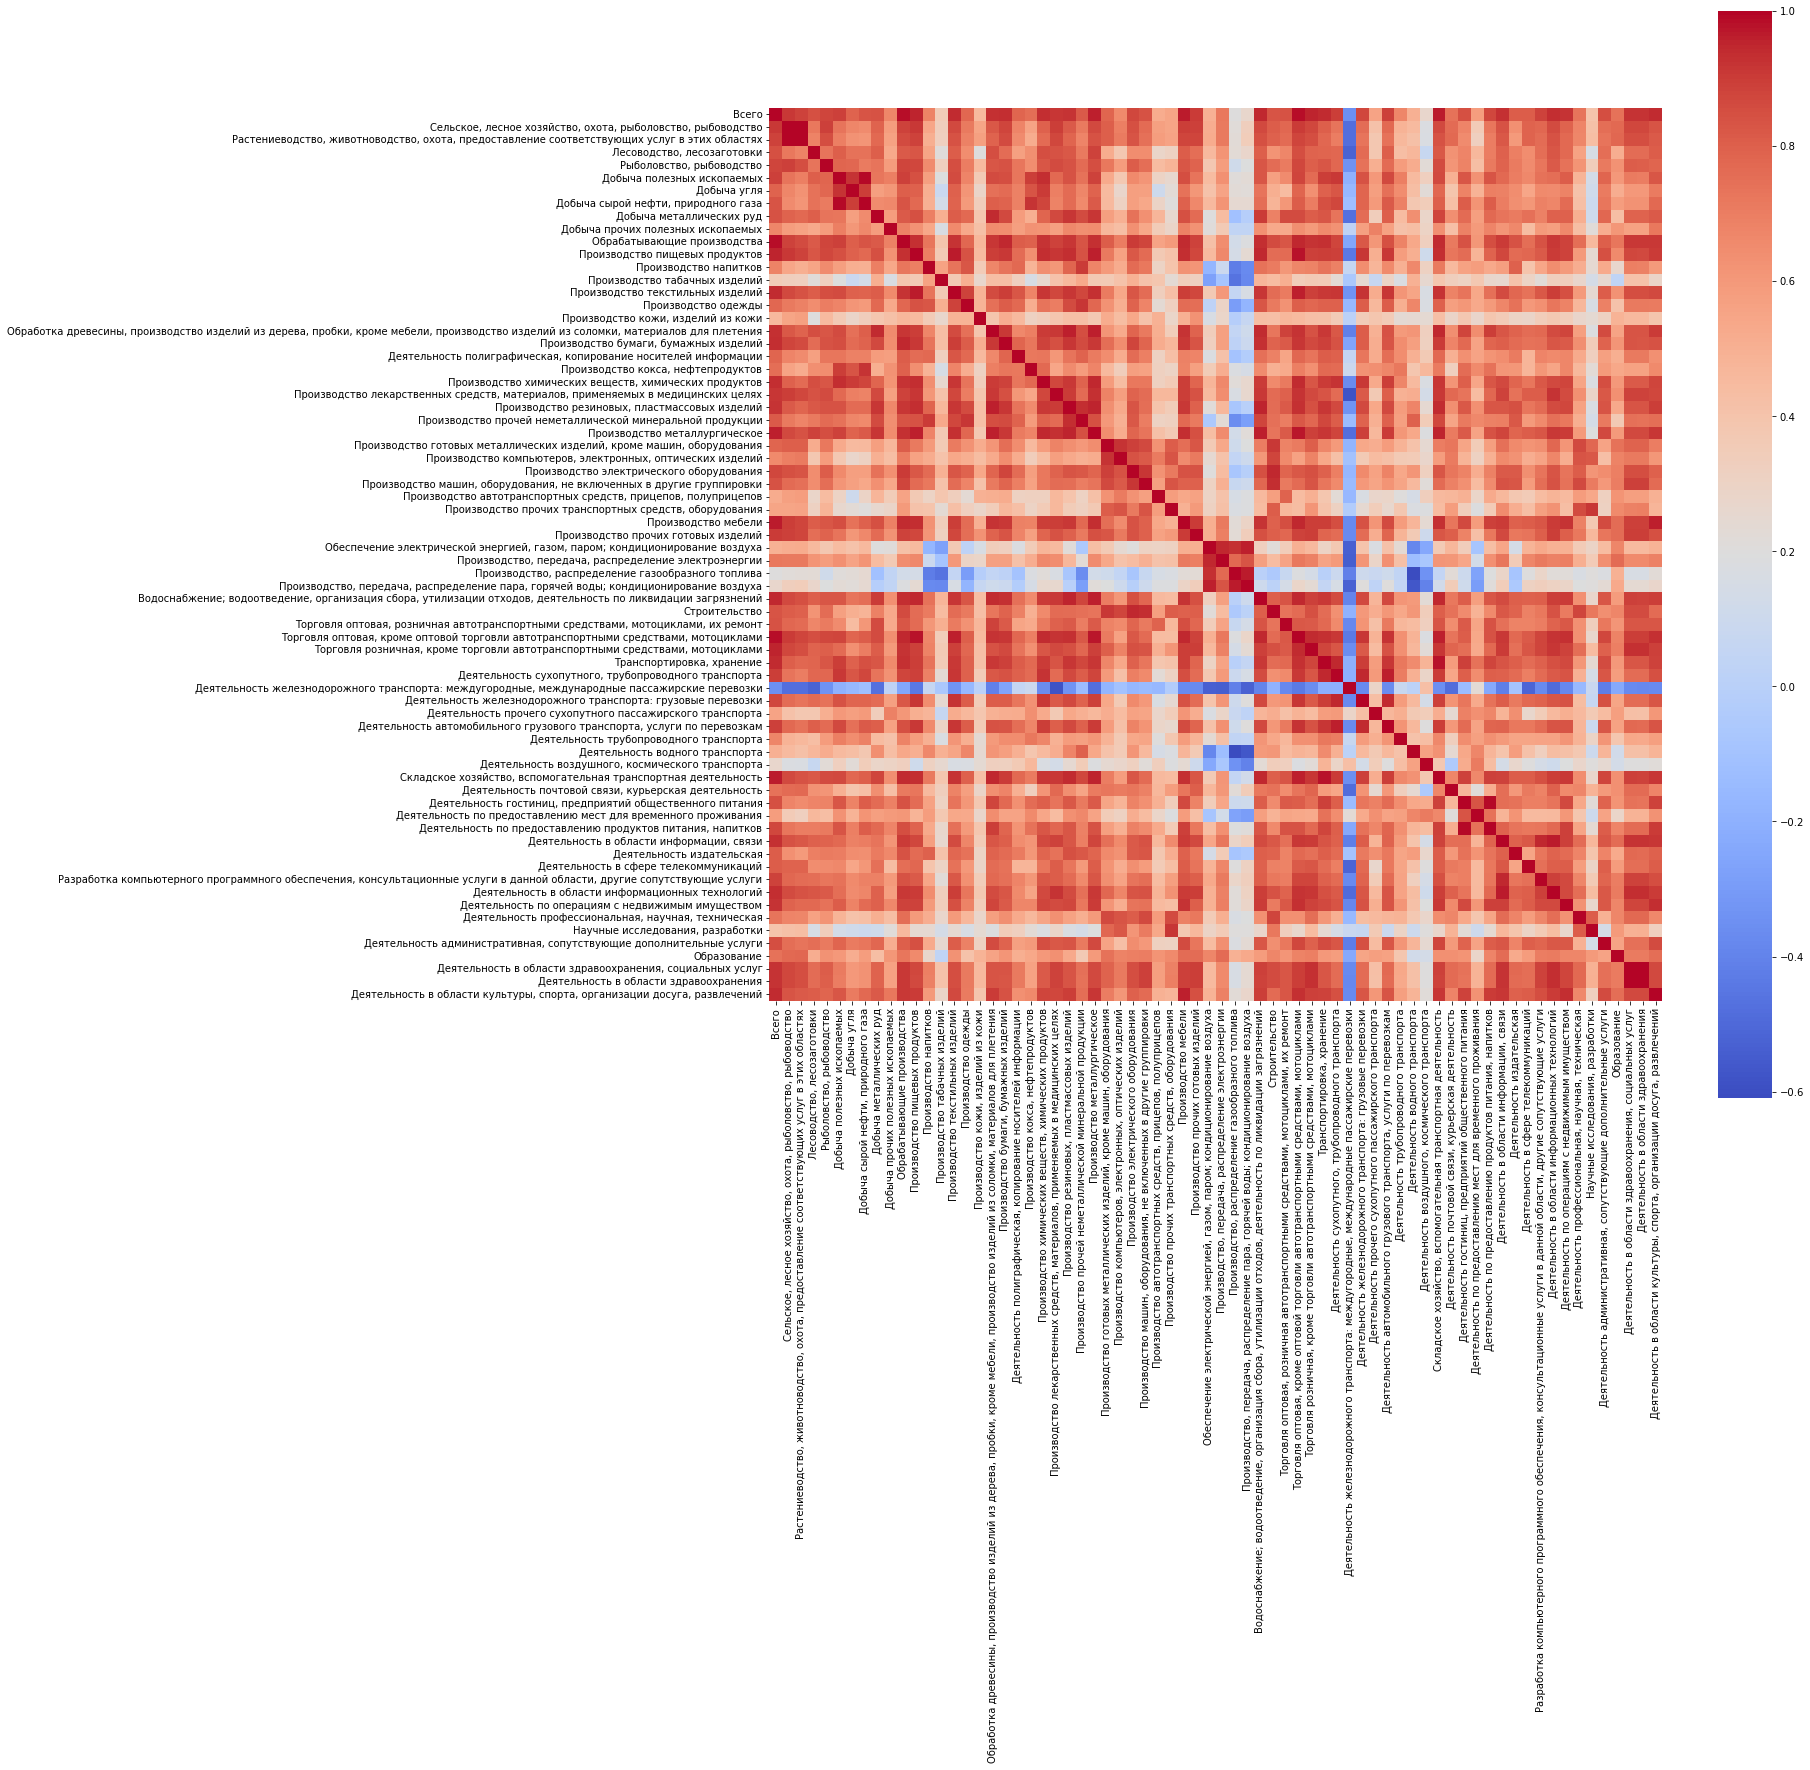

In [10]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_17_22.corr(), cmap='coolwarm', square=True)
plt.show()

<Figure size 1440x1440 with 0 Axes>

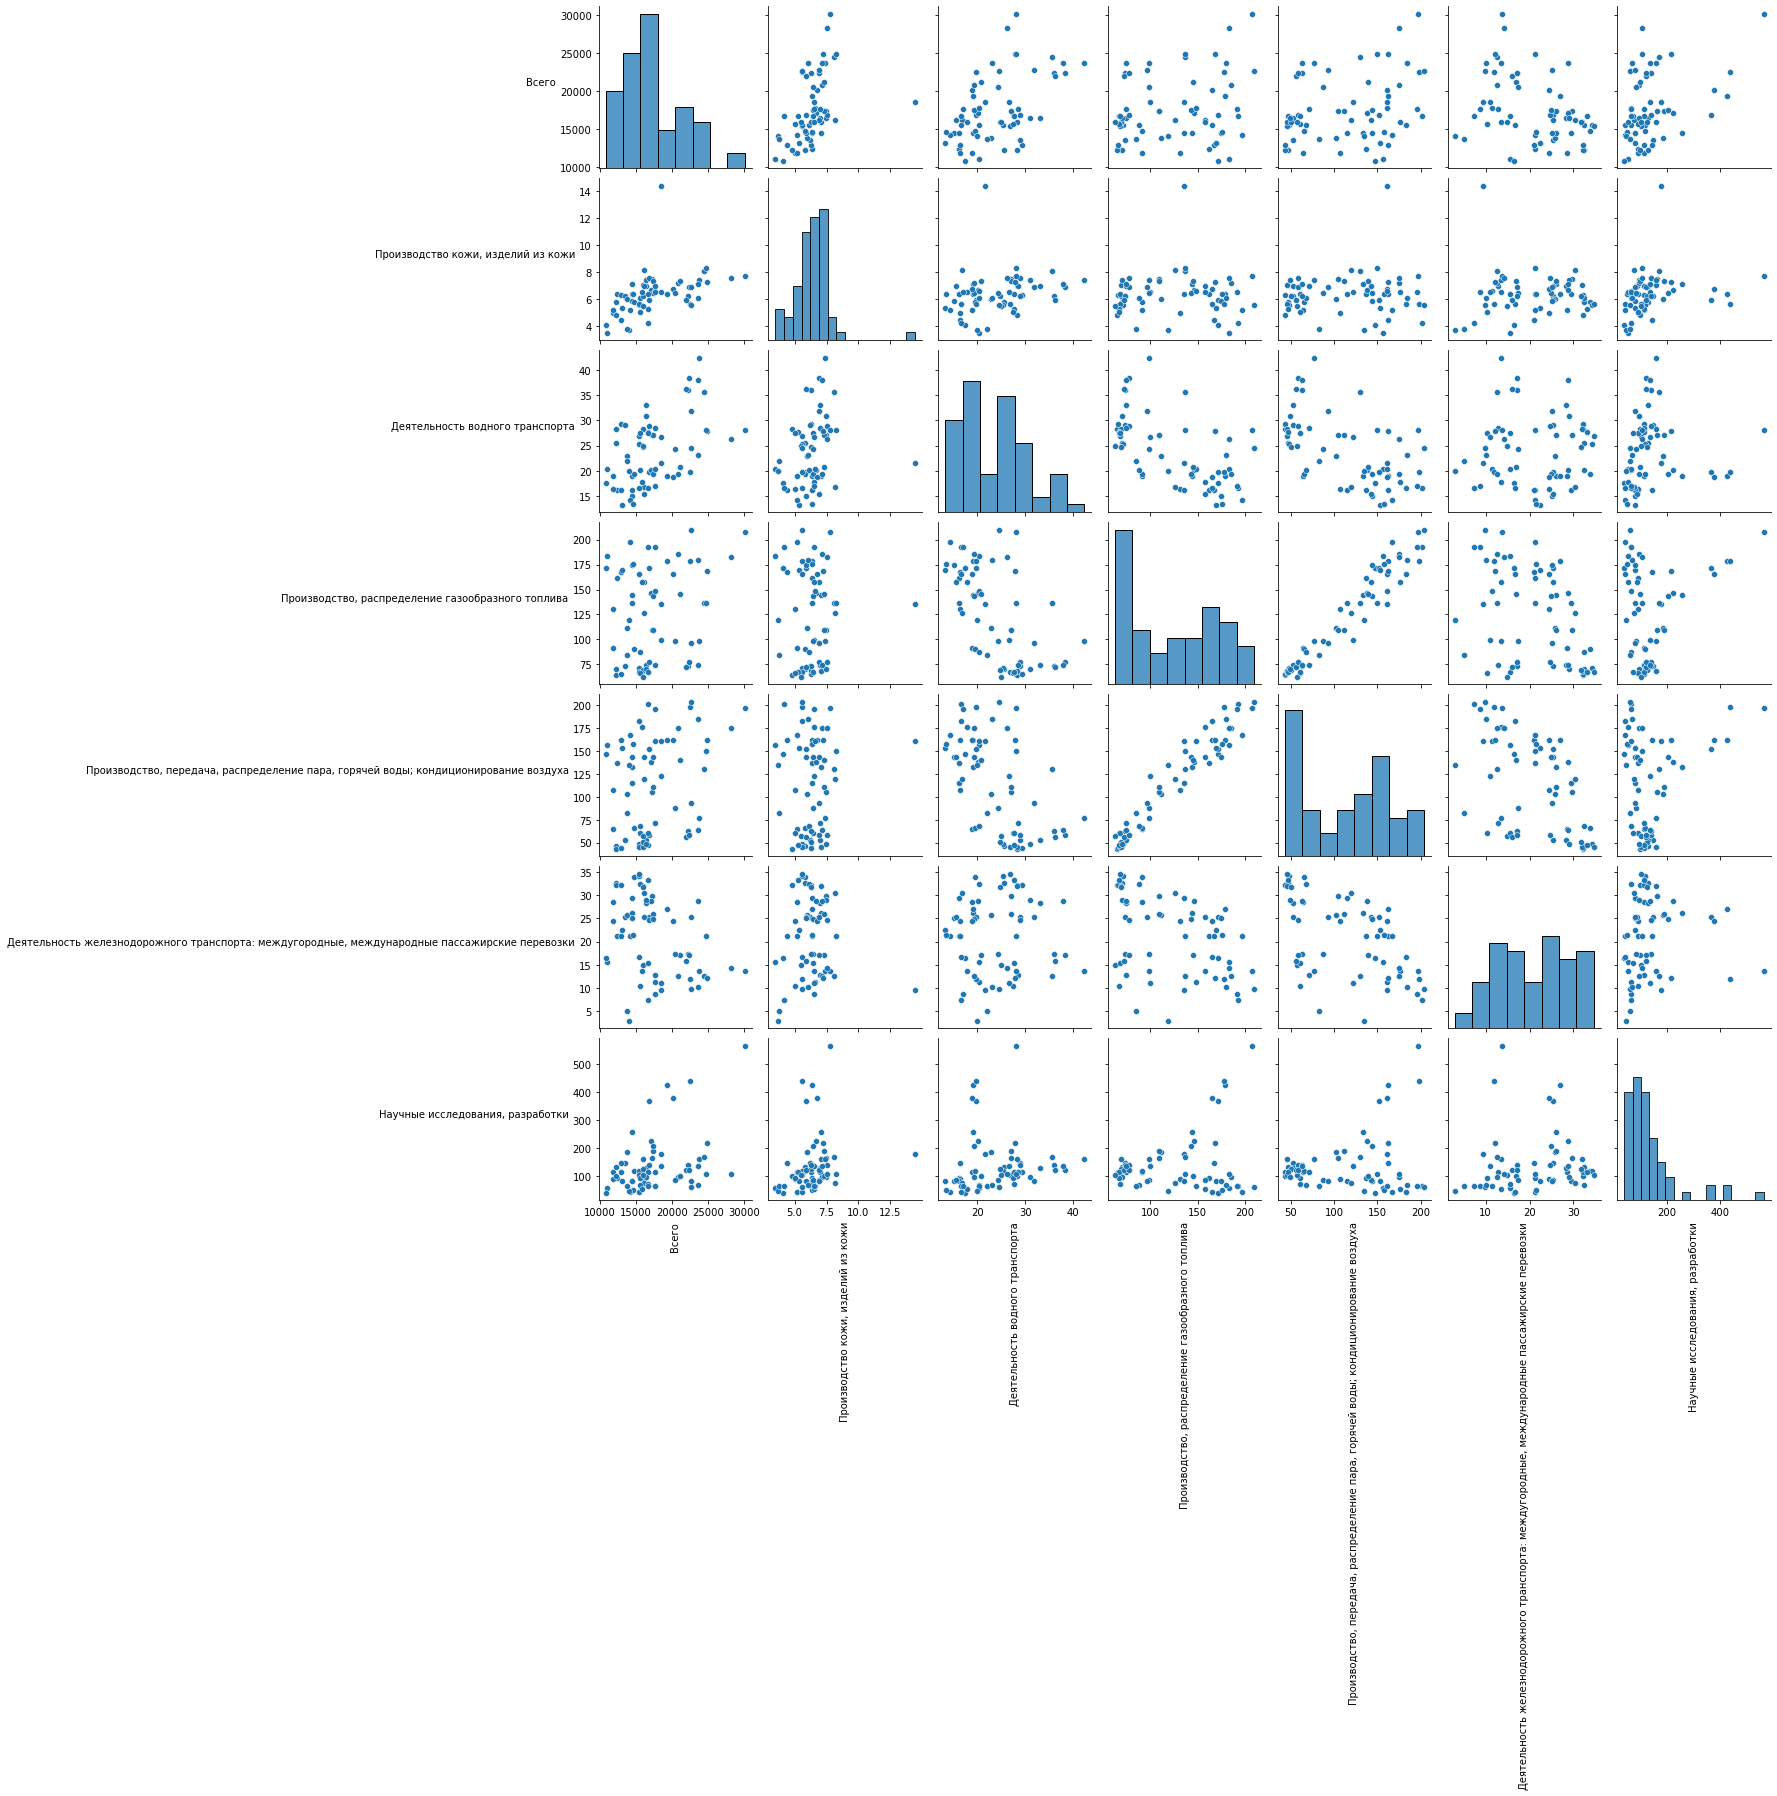

In [11]:
plt.figure(figsize=(20, 20))
g = sns.pairplot(
    df_17_22.loc[:,['Всего', 
                    'Производство кожи, изделий из кожи',
                    'Деятельность водного транспорта',
                    'Производство, распределение газообразного топлива',
                    'Производство, передача, распределение пара, горячей воды; кондиционирование воздуха',
                    'Деятельность железнодорожного транспорта: междугородные, международные пассажирские перевозки',
                    'Научные исследования, разработки']])
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    ax.yaxis.get_label().set_horizontalalignment('right')
plt.show()

В этой матрице диаграмм рассеяния особенно итересны 3 *"аутсайдера"* это: **"Производство, распределение газообразного топлива"**, **"Производство, передача, распределение пара, горячей воды; кондиционирование воздуха"** и **"Деятельность железнодорожного транспорта: междугородные, международные пассажирские перевозки"**. И если первые две напрямую связаны между собой, то третья ни визуально, ни по рассчетам не имеет прямой связи ни с одним из других параметров. Более того, деятельность железнодорожного транспорта имеет даже визуально слабую отрицательную линейную зависимость от других параметров. Из чего можно сделать вывод, что оборот данной отрасли не очень плавно, но ощутимо падает со временем.

## Объединение таблиц

In [12]:
df = pd.concat([df_05_16, df_17_22], join='inner')
df.head()

Всего  Рыболовство, рыбоводство  Добыча полезных ископаемых  \
2005-01-31  2301.729050                  2.291198                  186.835122   
2005-02-28  2462.974248                  3.058128                  199.912625   
2005-03-31  2750.346042                  6.284073                  236.289637   
2005-04-30  2782.331959                  6.654814                  243.632127   
2005-05-31  2740.964989                  3.882850                  257.886772   

            Обрабатывающие производства  Производство кокса, нефтепродуктов  \
2005-01-31                   570.891874                          129.350365   
2005-02-28                   627.645222                          134.981293   
2005-03-31                   733.506945                          156.359848   
2005-04-30                   753.582793                          171.349951   
2005-05-31                   764.955103                          189.183826   

            Производство резиновых, пластмассовых изделий  \
2005-01-31                                       8.881230   
2005-02-28                                      10.929277   
2005-03-31                                      13.181093   
2005-04-30                                      15.285110   
2005-05-31                                      14.916070   

            Производство, передача, распределение электроэнергии  \
2005-01-31                                         104.949064      
2005-02-28                                         111.287210      
2005-03-31                                         112.759154      
2005-04-30                                         100.009292      
2005-05-31                                          90.334479      

            Производство, распределение газообразного топлива  Строительство  \
2005-01-31                                           7.559260      65.152979   
2005-02-28                                          11.311679      71.353574   
2005-03-31                                          15.503101      86.459635   
2005-04-30                                          15.108646      94.920274   
2005-05-31                                          10.938221     100.604715   

            Деятельность воздушного, космического транспорта  \
2005-01-31                                         11.096877   
2005-02-28                                         10.891516   
2005-03-31                                         12.932111   
2005-04-30                                         13.851975   
2005-05-31                                         15.059839   

            Научные исследования, разработки  Образование  
2005-01-31                         19.910321     8.805628  
2005-02-28                         14.753508    10.405998  
2005-03-31                         24.553179    10.047283  
2005-04-30                         20.735658     9.106444  
2005-05-31                         18.333678     8.859028

Итого удалось свести 12 наименований.

Разложим временные ряды для всех сошедшихся наименований на компоненты и сохраним изображения в словарь (если все отображать в тетрадке получится длинная и неудобная простыня).

In [13]:
graphs = {}
for column in df.columns:
    decomposition = seasonal_decompose(df[column], model='additive', period=12)
    fig = decomposition.plot()
    fig.set_size_inches((16, 9))
    decomposition.seasonal.plot()
    plt.tight_layout()
    plt.close()
    zoom = plt.figure(figsize=(10, 5))
    decomposition.seasonal['2018-01-01':'2018-12-31'].plot()
    plt.title(column)
    plt.close()
    graphs[column] = (fig, zoom)

### Всего

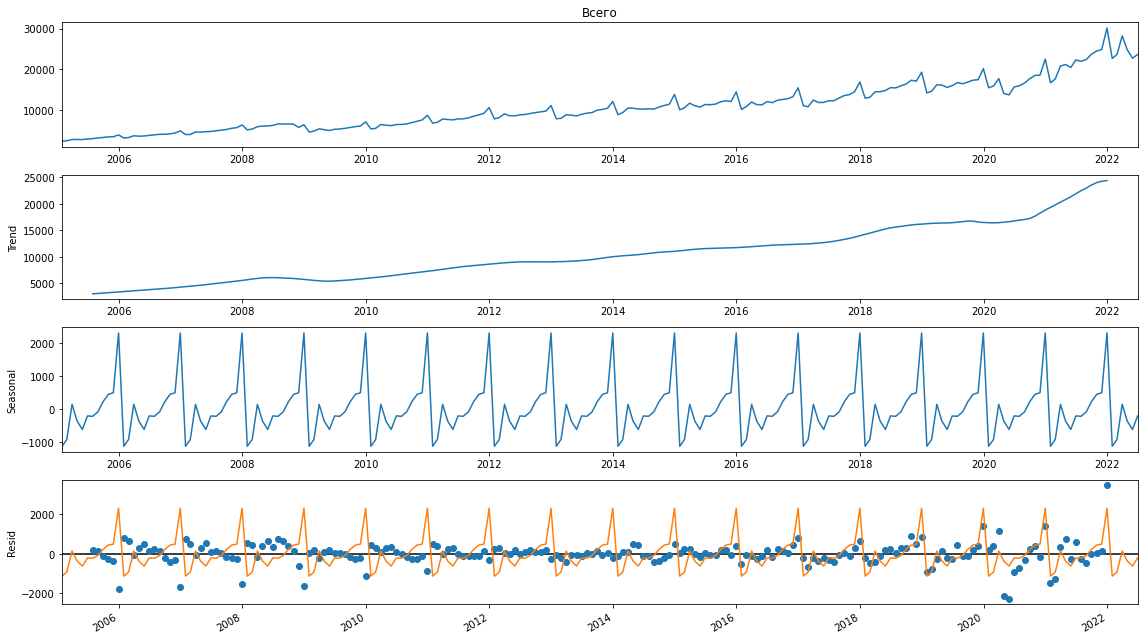

In [14]:
graphs['Всего'][0]

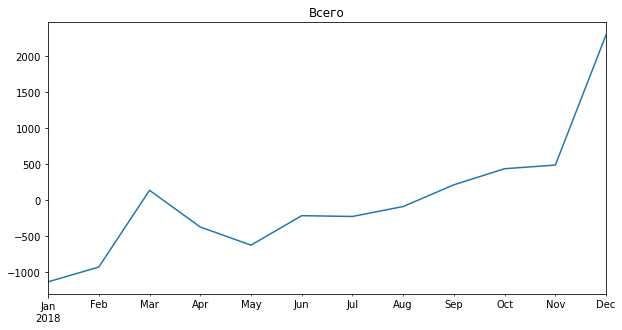

In [15]:
graphs['Всего'][1]

Линия тренда общего оборота стабильно растет до 2020 года, слегка падает до 2021, после рост несколько ускоряется. 

Наблюдается выраженная сезонность. Согласно сезонности общий оборот растет с начала года по март, после несколько падает до мая, а после мая растет до конца года.

Видно, что с каждым годом сезонность растет пропорционально росту оборота. Если наложить график сезонности на график остатков это особенно хорошо заметно.

### Рыболовство, рыбоводство

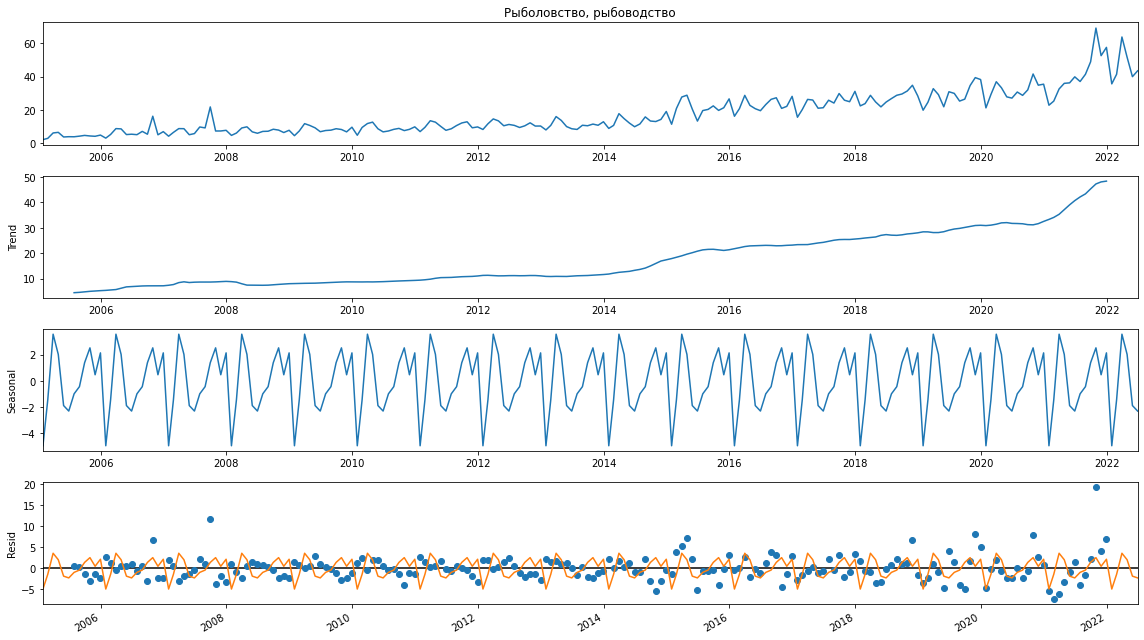

In [16]:
graphs['Рыболовство, рыбоводство'][0]

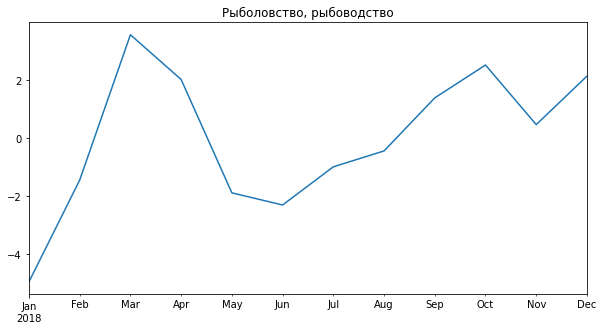

In [17]:
graphs['Рыболовство, рыбоводство'][1]

Общий график "зубастый" из-за выраженного влияния сезонности и периодически встречающихся выбросов. Пики сезонности приходятся на март и октябрь.

### Добыча полезных ископаемых

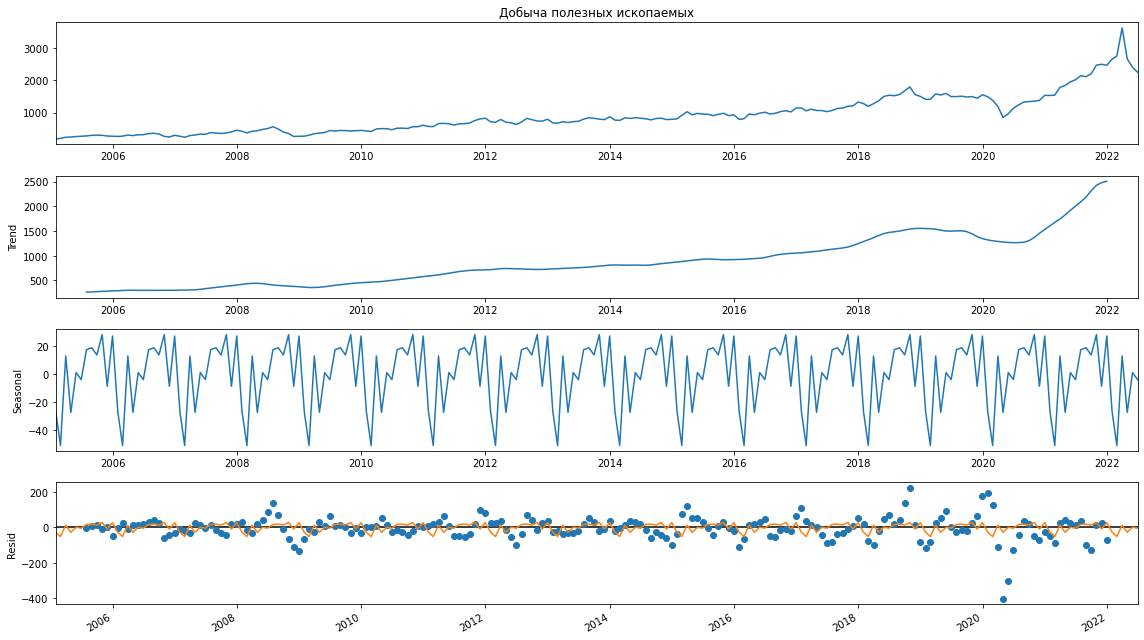

In [18]:
graphs['Добыча полезных ископаемых'][0]

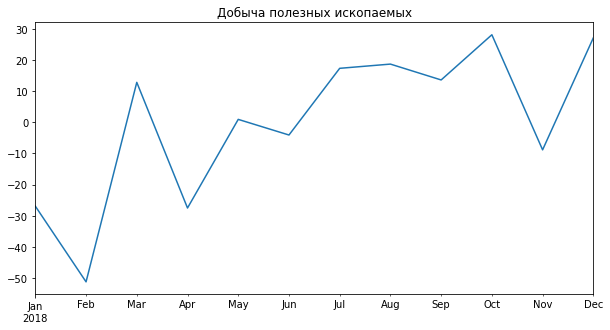

In [19]:
graphs['Добыча полезных ископаемых'][1]

Относительно объема оборота добычи полезных ископаемых сезонность выражена довольно слабо. В середине 2020-го года оборот сильно проседает, к 2022 сильно растет.

### Обрабатывающие производства

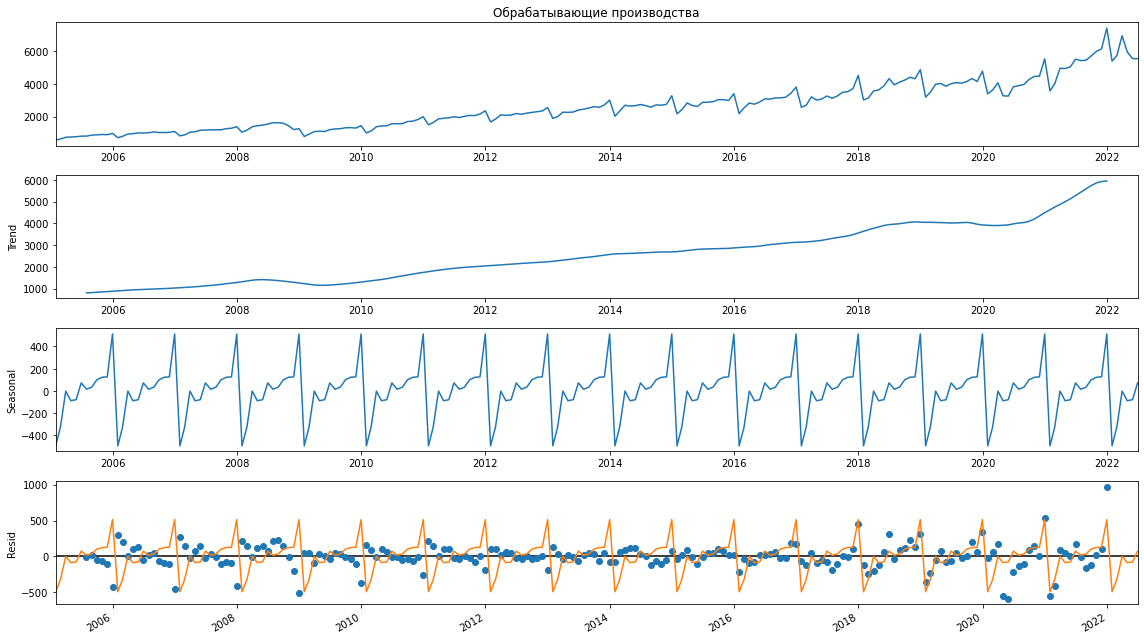

In [20]:
graphs['Обрабатывающие производства'][0]

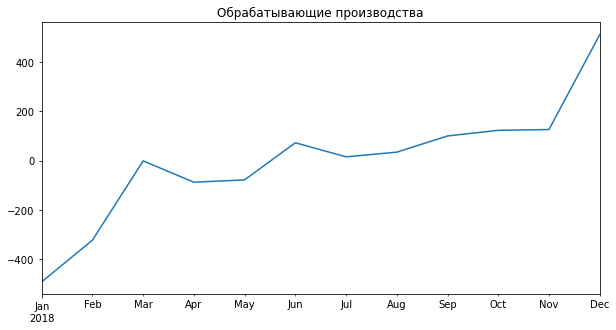

In [21]:
graphs['Обрабатывающие производства'][1]

Стабильно растущая в течение года и от года к году сезонность.

### Производство кокса, нефтепродуктов

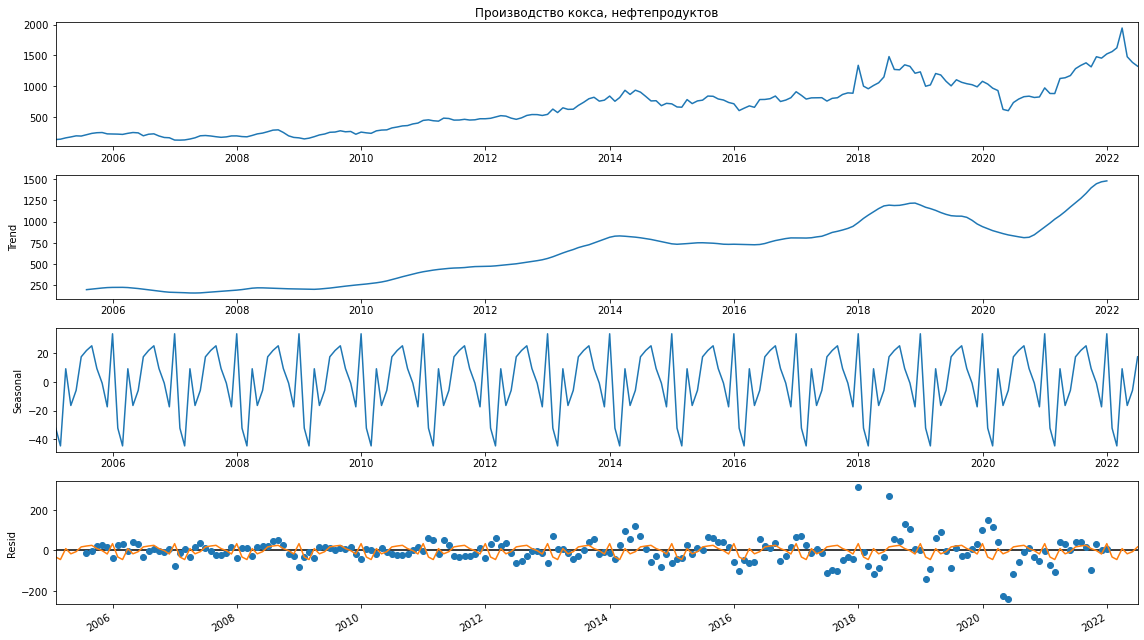

In [22]:
graphs['Производство кокса, нефтепродуктов'][0]

Сезонность слабая, имеется несколько выбросов. Очень похожее на добычу полезных ископаемых проседание в 2020-2021-ом году, хотя в таблице **"Производство кокса, нефтепродуктов"** не явлеяется подгруппой **"Добыча полезных ископаемых"**

### Производство резиновых, пластмассовых изделий

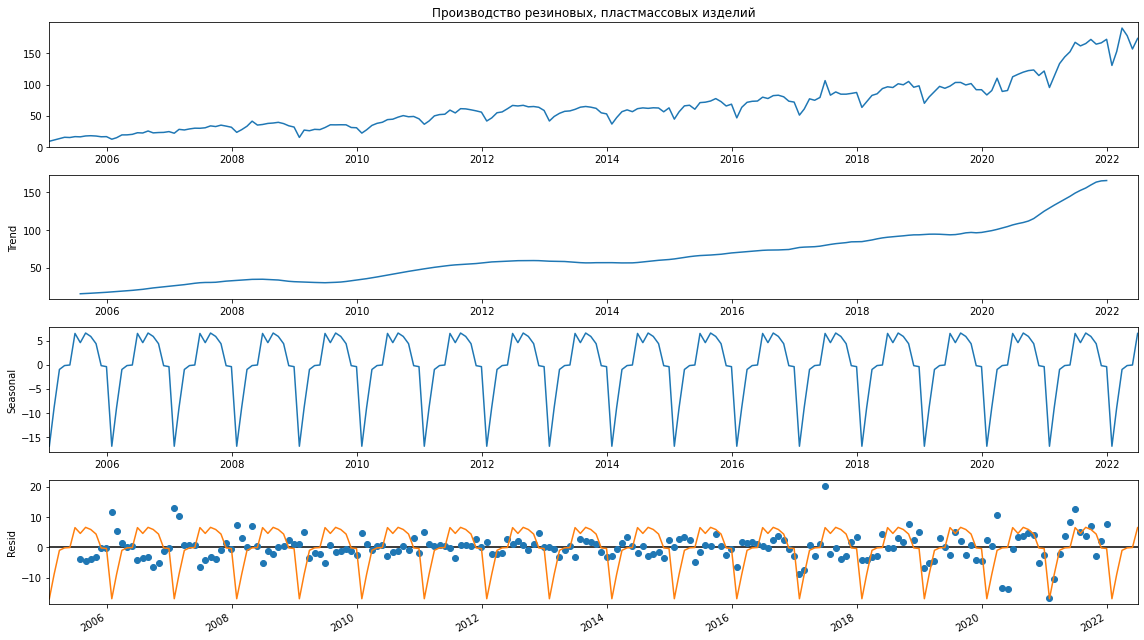

In [23]:
graphs['Производство резиновых, пластмассовых изделий'][0]

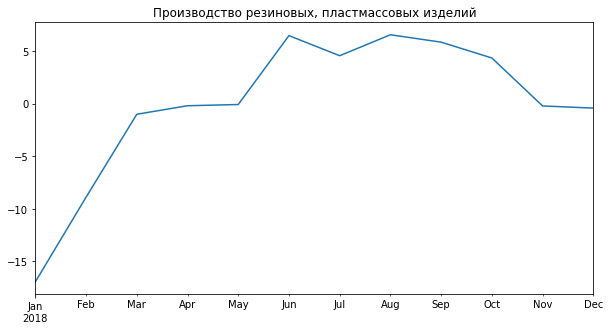

In [24]:
graphs['Производство резиновых, пластмассовых изделий'][1]

Стабильное падение оборота в январе. Как и во всех других оборотах.

### Производство, передача, распределение электроэнергии

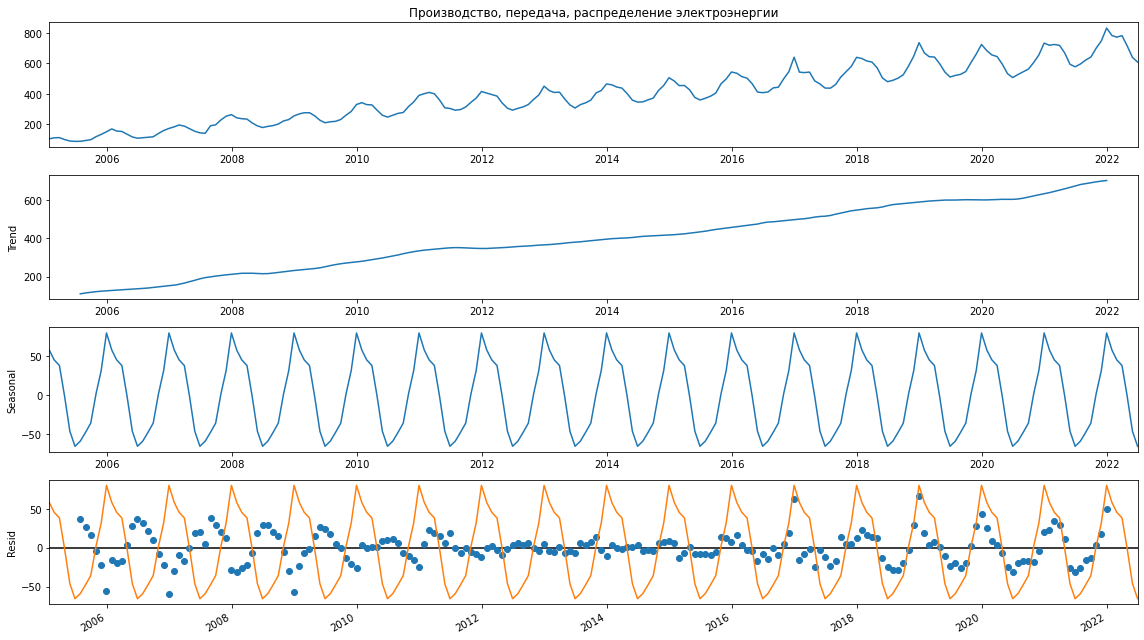

In [25]:
graphs['Производство, передача, распределение электроэнергии'][0]

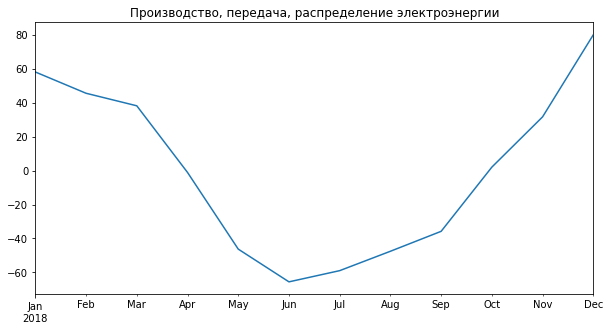

In [26]:
graphs['Производство, передача, распределение электроэнергии'][1]

Ярко выраженная сезонность. Оборот выше в зимние месяцы. Видимо много электричества уходит на отопление.

### Производство, распределение газообразного топлива

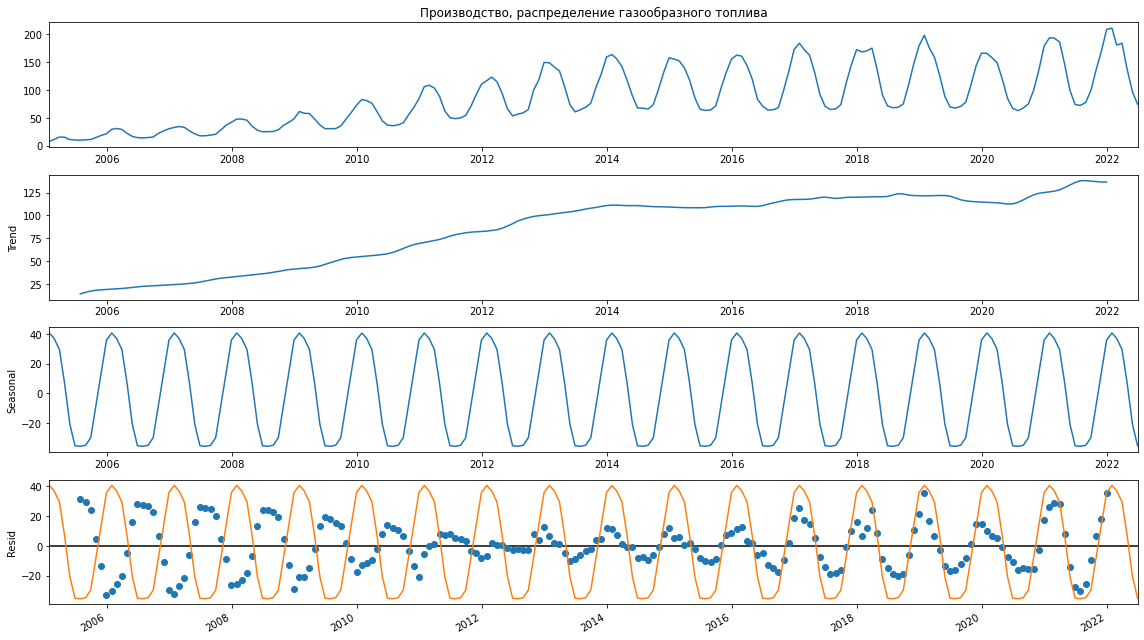

In [27]:
graphs['Производство, распределение газообразного топлива'][0]

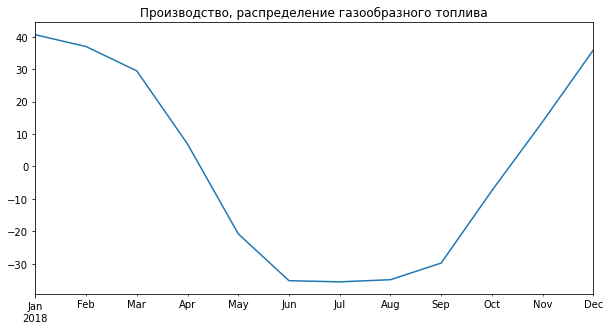

In [28]:
graphs['Производство, распределение газообразного топлива'][1]

Схожая, даже еще более выраженная сезонность, что и в прошлом пункте. Вполне логично, зимой надо топить.

### Строительство

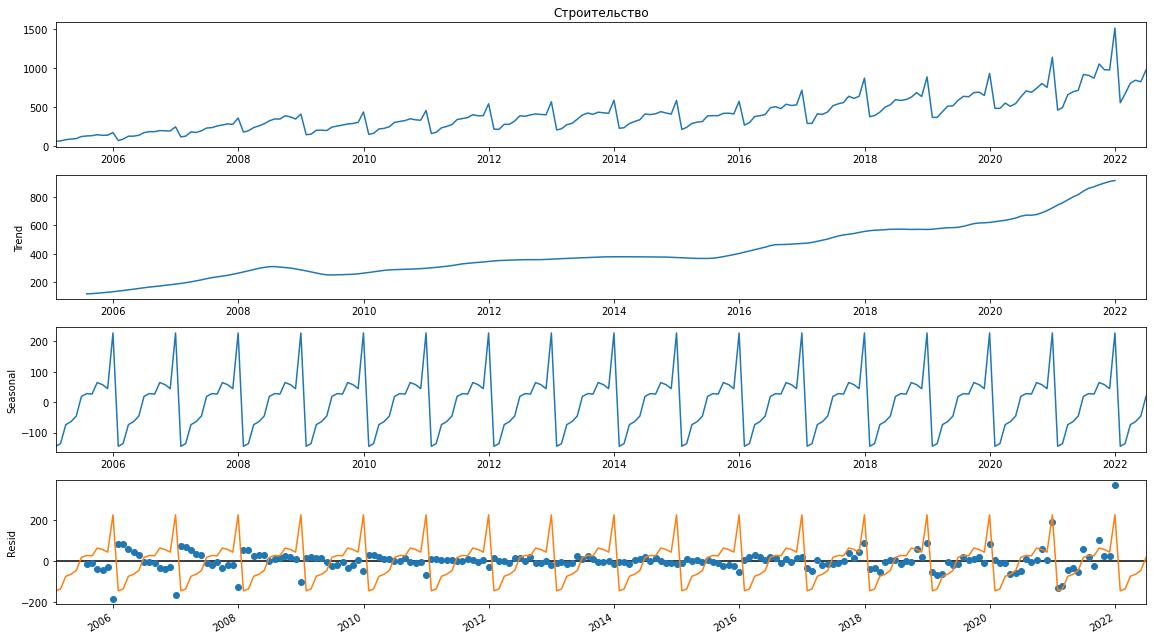

In [29]:
graphs['Строительство'][0]

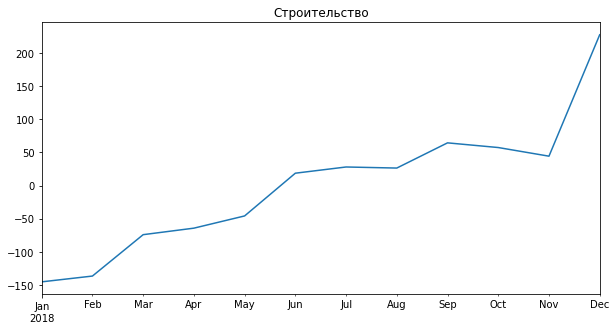

In [30]:
graphs['Строительство'][1]

Сезонный рост в течение всего года.

### Деятельность воздушного, космического транспорта

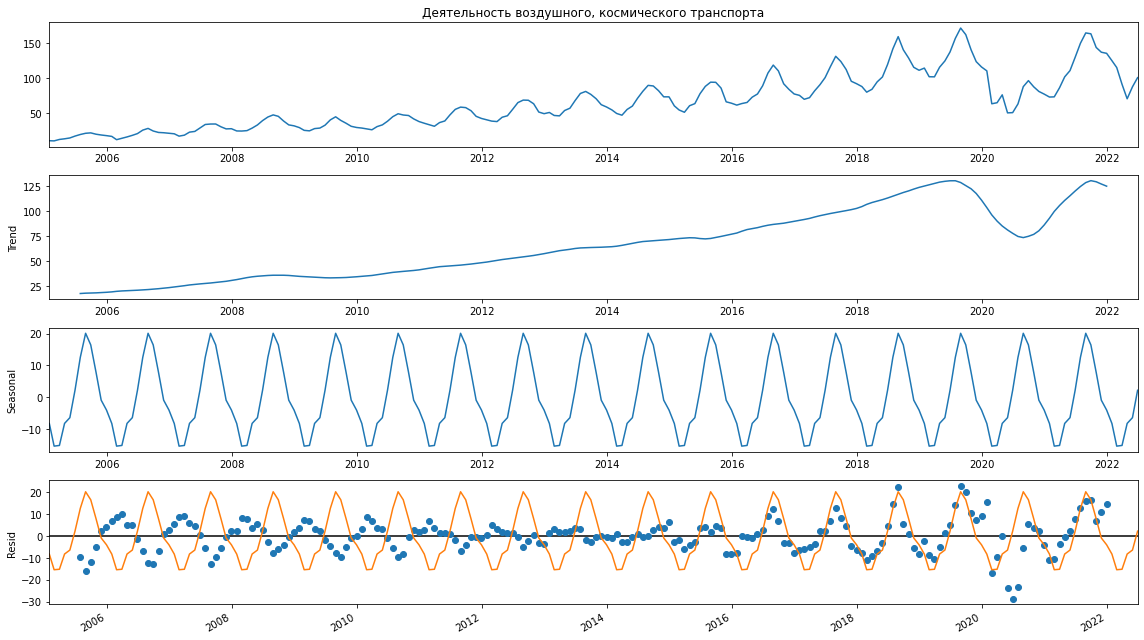

In [31]:
graphs['Деятельность воздушного, космического транспорта'][0]

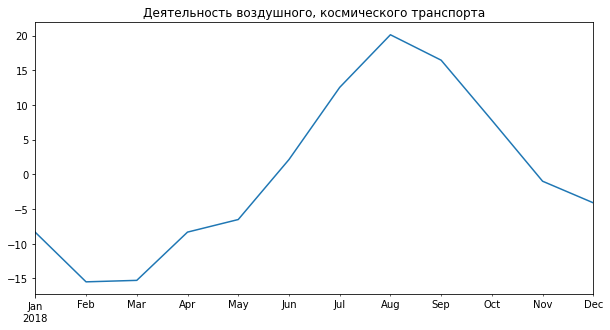

In [32]:
graphs['Деятельность воздушного, космического транспорта'][1]

На графике очень хорошо видно когда появился COVID. Его влияние прослеживается и на предыдущих наименованиях, но на воздушном транспорте он особенно заметен. Каджый год традиционно оборот растет к сезону отпусков.

### Научные исследования, разработки

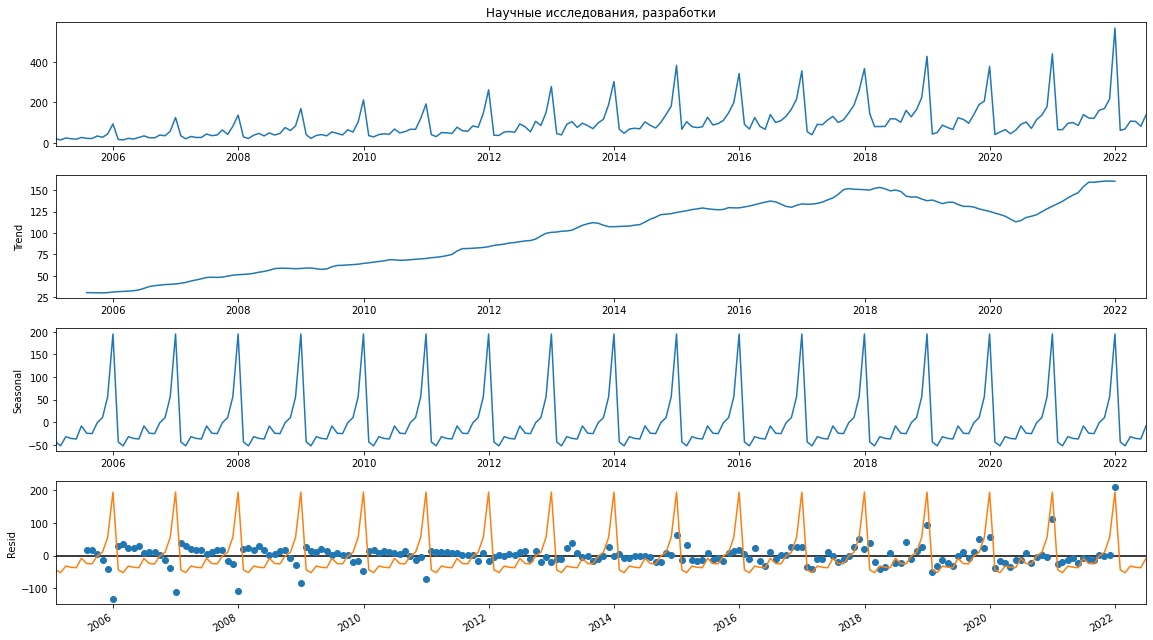

In [33]:
graphs['Научные исследования, разработки'][0]

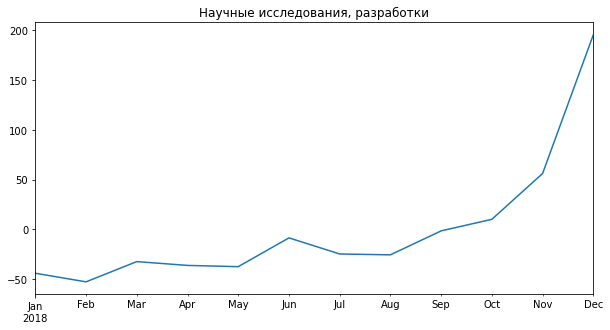

In [34]:
graphs['Научные исследования, разработки'][1]

Очень сильные пики каждый декабрь, во многих дргих отраслях также наблюдался пик в декабре и спад в январе. Но здесь это выраженно особо ярко.

### Образование

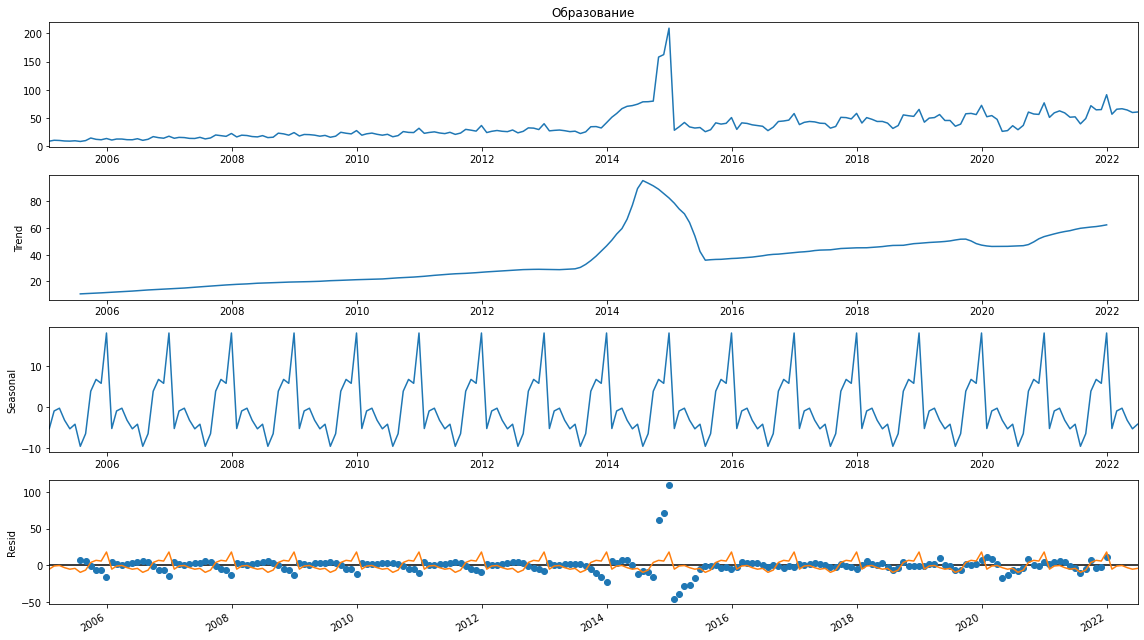

In [35]:
graphs['Образование'][0]

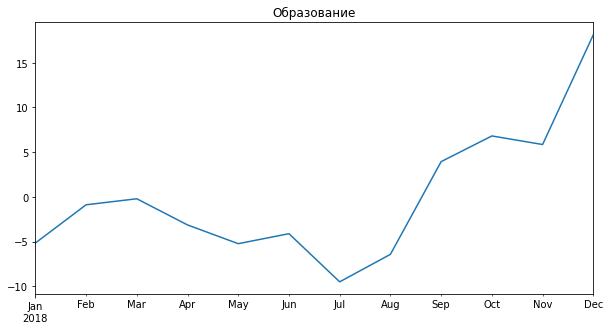

In [36]:
graphs['Образование'][1]

Огромный и широкий пик в 2014-2015 гг. Вероятно это связанно с каким-то событием о котором я не осведомлен. Падение оборота летом вероятно связано с каникулами.

### Обзор роста сезонности

Было замечено, что сезонность с каждым годом равномерно растет в объеме. Чтобы измерить этот рост посмотрим как сезонность вкупе с остатками растет от года к году. Мерой изменчивости сезонности по годам выберем стандартное отклонение.

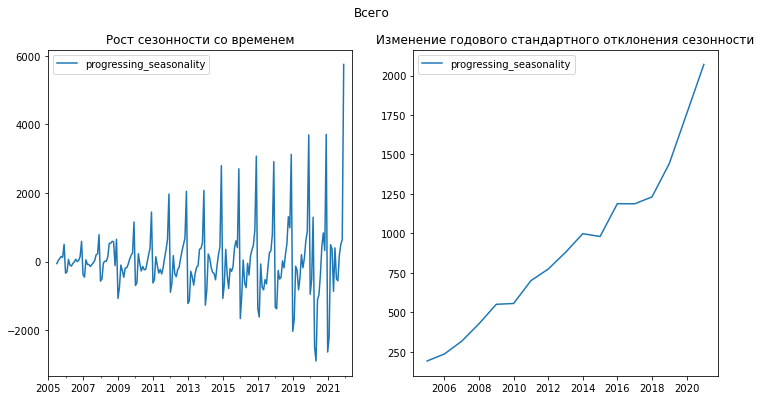

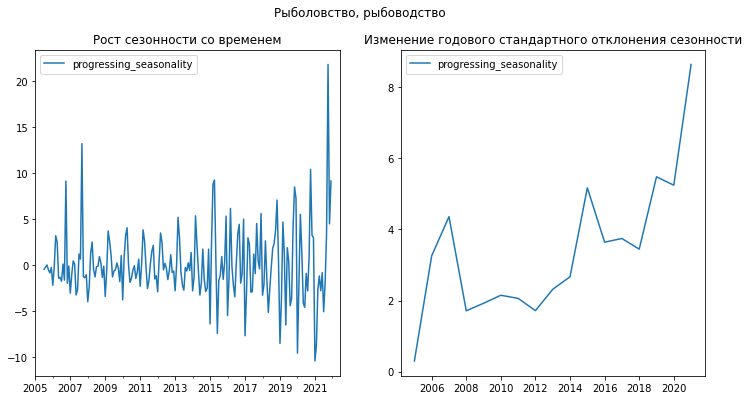

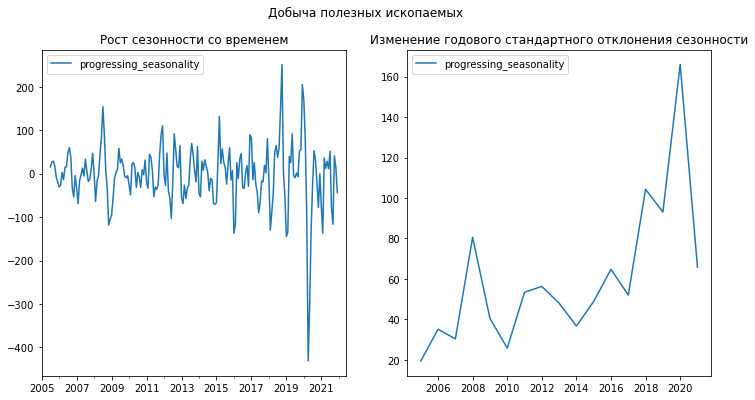

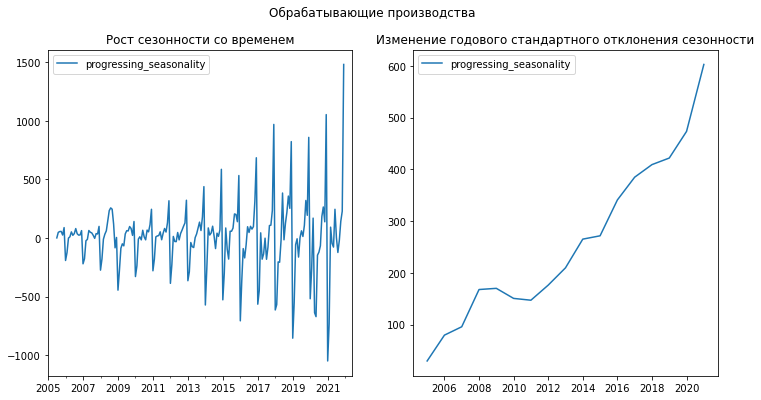

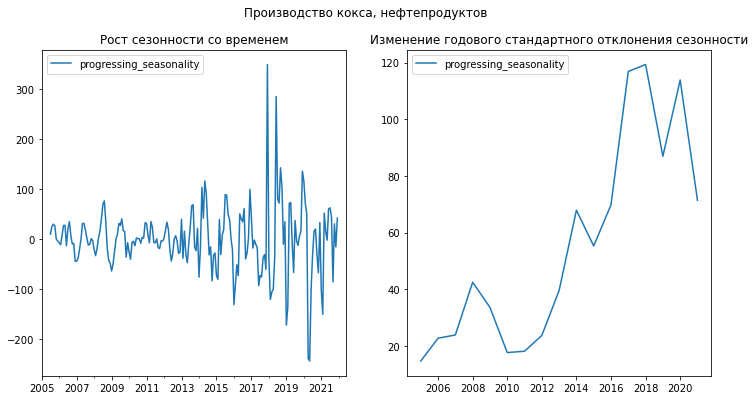

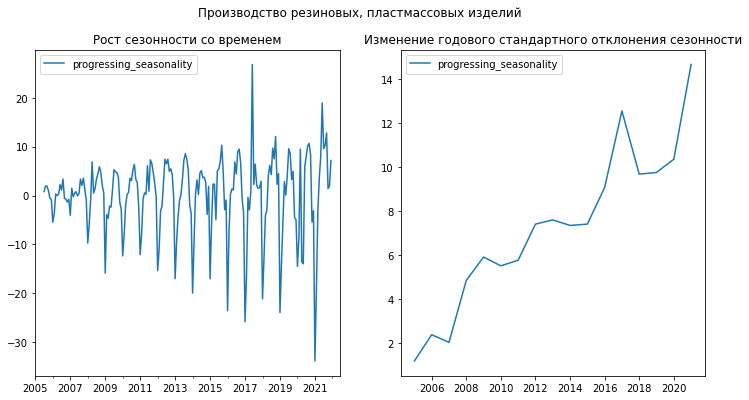

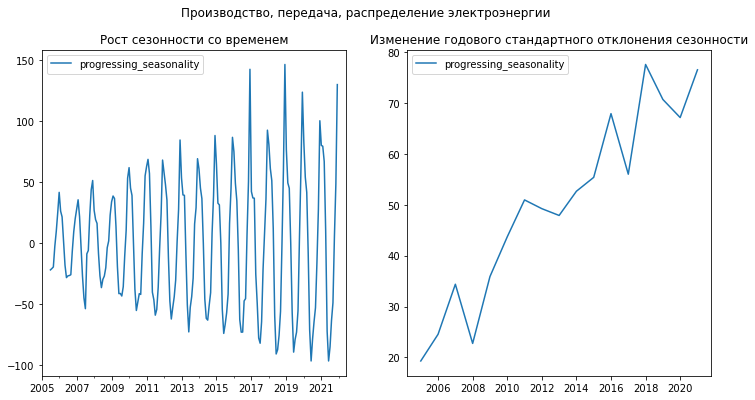

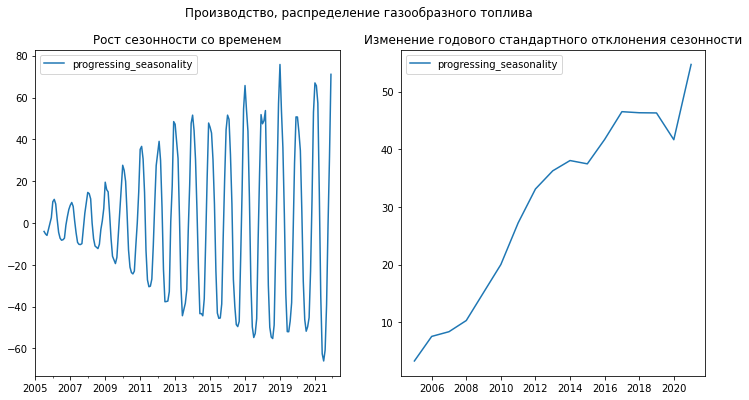

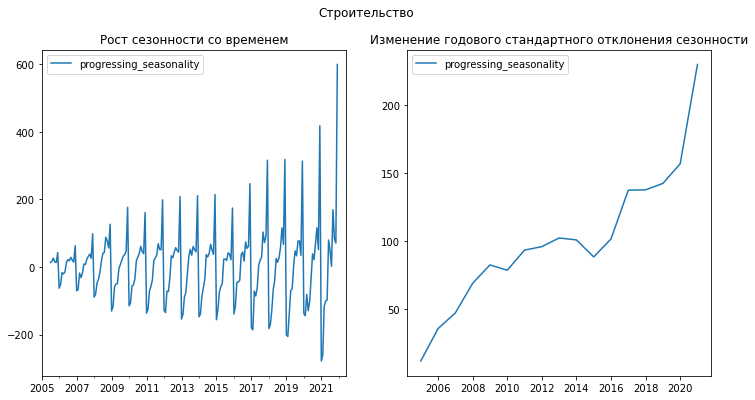

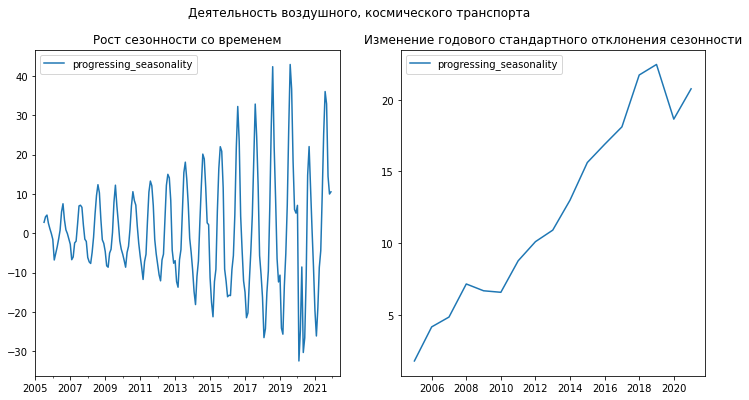

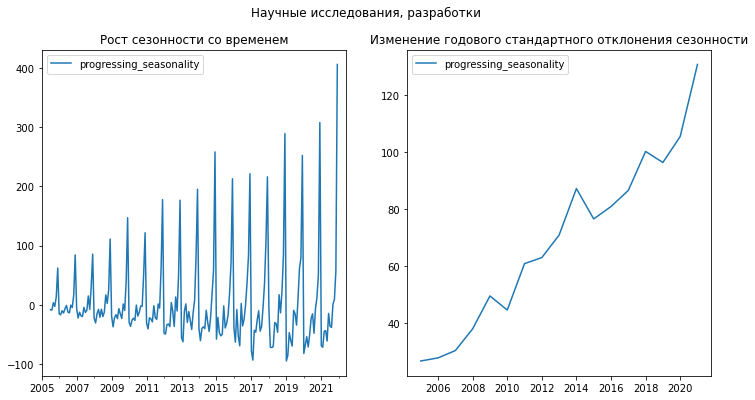

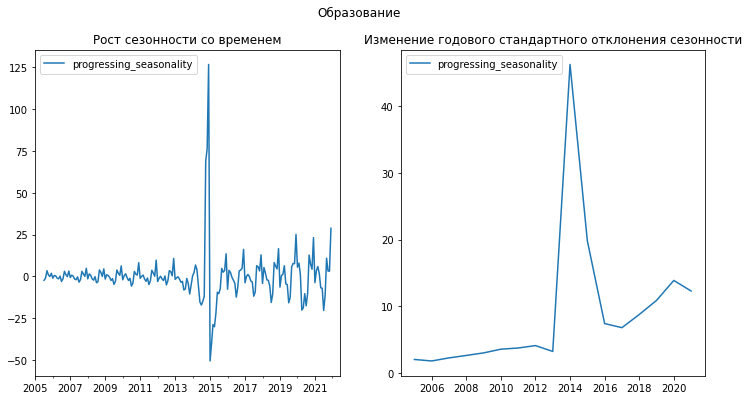

In [37]:
for column in df.columns:
    decomposition = seasonal_decompose(df[column], model='additive', period=12)
    rew = pd.DataFrame(decomposition.seasonal + decomposition.resid, columns=['progressing_seasonality'])
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(column)
    rew.plot(ax=axes[0])
    axes[0].set_title('Рост сезонности со временем')
    rew.groupby(rew.index.year).std().plot(ax=axes[1])
    axes[1].set_title('Изменение годового стандартного отклонения сезонности')
    plt.show()

Видно, что в рост стандартного отклонения по годам в некоторых случаях очень похож на линейный, в некоторых он похож на линейный с некоторой натяжкой, но мне этого достаточно.

## Вывод

Оборот растет, единстванная отрасль в которой рост больше рохож на падение это:**"Деятельность железнодорожного транспорта: междугородные, международные пассажирские перевозки"**.

Объем сезонности растет пропорционально росту объема оборота.

Как на общем развитии оборота, так и на обороте большинства ответвлений серьезный след оставил COVID-19. Он вызвал падение оборота в 2020 во многих областях бизнеса. Однако к началу 2021 года удалось выбраться из снижения оборота вызванного COVID, и, более того, увеличить темп роста оборота во многих областях. 

Во многих ответвлениях (кроме связанных с энергетикой) наблюдается выраженный сезонный рост оборота от начала года к концу. Однако при переходе от декабря к январю следующего года наблюдается резкое падение. Особенно выражено это в отрасли **"Научные исследования, разработки"**. Скорее всего это связано с манерой ведения отчетности и с разным отношением к ведению учета оборота в течение года.

Сезонность линейно или почти линейно растет от года к году.

# Построение моделей

В качестве тестовой выборки возьмем последние 20% значений. Сразу можно сказать, что тест выйдет довольно суровый, так именно на эти 20% придется COVID, который сильно снизил оборот и на внезапный рост в 2022. Скорее всего все модели покажут себя плохо на данном участке. Но зато это честно, так как непредсказуемые явления в реальном мире никто не отменял.

In [38]:
train, test = train_test_split(df, test_size = 0.2, shuffle=False)

## Dummy модель. Проверка на адекватность

Первая dummy_lag модель - это модель прогнозирет показатель следующего месяца равным показателю нынешнего.

In [39]:
dummy_lag_pred = test.shift(1)
dummy_lag_pred.iloc[0, :] = train.iloc[-1, :]

Упакуем показатели метрик данной модели на  тестовой выборке в датафрейм с помощью функции.

In [40]:
def results_to_table(test, pred, method_name):
    scores = {'R2' : r2_score, "MAE" : mean_absolute_error, 'MAPE' : mean_absolute_percentage_error}
    d = {}
    for column in test.columns:
        d[column] = pd.DataFrame([score(test[column], pred[column]) for score in scores.values()], index=[name for name in scores.keys()], columns=[method_name])
    result = pd.concat(d.values(), keys=d.keys())
    return result

In [41]:
results_dummy = results_to_table(test, dummy_lag_pred, 'dummy_lag_test')
results_dummy.head()

dummy_lag_test
Всего                    R2          0.588444
                         MAE      1748.130853
                         MAPE        0.090293
Рыболовство, рыбоводство R2          0.314326
                         MAE         6.983186

Теперь когда есть метрики на dummy модели можно приступать к построению более интересных моделей.

## Тройное экспоненциальное сглаживание 

Скорее всего покажет не настолько хороший рузультат как бы хотелось, так как не рассчитано на резкие перепады в тренде (спасибо, COVID).

In [42]:
exp_pred = {}
exp_pred_train = {}
for column in df.columns:
    exp_fit = ExponentialSmoothing(train[column], trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True, method='least_squares')
    exp_pred_train[column] = exp_fit.fittedvalues
    exp_pred[column] = exp_fit.forecast(len(test))
exp_pred_train = pd.DataFrame(exp_pred_train)
exp_pred = pd.DataFrame(exp_pred)

In [43]:
total_results = results_dummy.join(results_to_table(train ,exp_pred_train, 'smoothing_train'))
total_results = total_results.join(results_to_table(test, exp_pred, 'smoothing_test'))

In [44]:
total_results

dummy_lag_test  \
Всего                                              R2          0.588444   
                                                   MAE      1748.130853   
                                                   MAPE        0.090293   
Рыболовство, рыбоводство                           R2          0.314326   
                                                   MAE         6.983186   
                                                   MAPE        0.199669   
Добыча полезных ископаемых                         R2          0.824642   
                                                   MAE       134.310866   
                                                   MAPE        0.073339   
Обрабатывающие производства                        R2          0.493311   
                                                   MAE       481.656858   
                                                   MAPE        0.108130   
Производство кокса, нефтепродуктов                 R2          0.781047   
                                                   MAE        90.332164   
                                                   MAPE        0.082612   
Производство резиновых, пластмассовых изделий      R2          0.793346   
                                                   MAE        11.295252   
                                                   MAPE        0.095471   
Производство, передача, распределение электроэн... R2          0.724356   
                                                   MAE        36.795321   
                                                   MAPE        0.057327   
Производство, распределение газообразного топлива  R2          0.708320   
                                                   MAE        20.982190   
                                                   MAPE        0.180105   
Строительство                                      R2         -0.217748   
                                                   MAE       139.804425   
                                                   MAPE        0.222629   
Деятельность воздушного, космического транспорта   R2          0.784278   
                                                   MAE        12.296243   
                                                   MAPE        0.127983   
Научные исследования, разработки                   R2         -0.995497   
                                                   MAE        76.717514   
                                                   MAPE        0.960258   
Образование                                        R2          0.026415   
                                                   MAE         9.558084   
                                                   MAPE        0.187999   

                                                         smoothing_train  \
Всего                                              R2           0.993955   
                                                   MAE        208.759729   
                                                   MAPE         0.027114   
Рыболовство, рыбоводство                           R2           0.905267   
                                                   MAE          1.633921   
                                                   MAPE         0.144776   
Добыча полезных ископаемых                         R2           0.983176   
                                                   MAE         34.259027   
                                                   MAPE         0.055983   
Обрабатывающие производства                        R2           0.988721   
                                                   MAE         71.868565   
                                                   MAPE         0.037636   
Производство кокса, нефтепродуктов                 R2           0.966114   
                                                   MAE         35.721415   
                                                   MAPE         0.076680   
Производство резиновых, пластмассовых изделий      R2           0

Сглаживание в тестовой выборке показало себя хуже чем dummy модель в тех случаях когда влияние COVID было слишком велико. И наоборот показало себя в лучше в тех областях на которые COVID не повлиял или повлиял слабо.

Dummy модель показала себя хуже в тех областях где сезонность выражена очень остро. Как например в **"Научные исследования, разработки"**

Напишем функцию для отображения результатов.

In [45]:
def show_results_graph(train, train_pred, test, test_pred, column):
    """
    Функция для сравнивания результатов модели и реальных данных в графическом виде.
    """
    plt.figure(figsize= (12,3))
    train[column].plot()
    train_pred[column].plot()
    plt.title(column + ' | тренировочная выборка')
    plt.legend(('Ground True', 'Model'))
    plt.show()
    plt.figure(figsize= (12,3))
    test[column].plot()
    test_pred[column].plot()
    plt.title(column)
    plt.title(column + ' | тестовая выборка')
    plt.legend(('Ground True', 'Model'))
    plt.show()

И посмотрим на результаты.

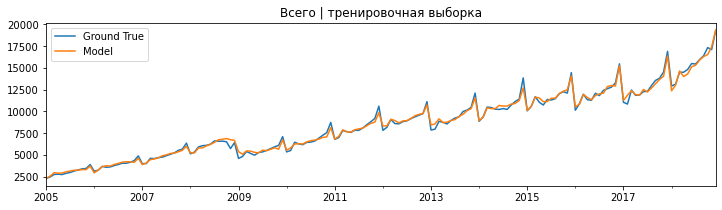

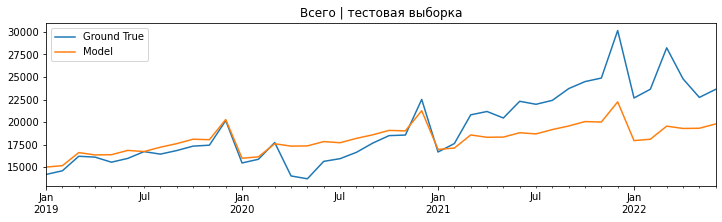

In [46]:
show_results_graph(train, exp_pred_train, test, exp_pred, 'Всего')

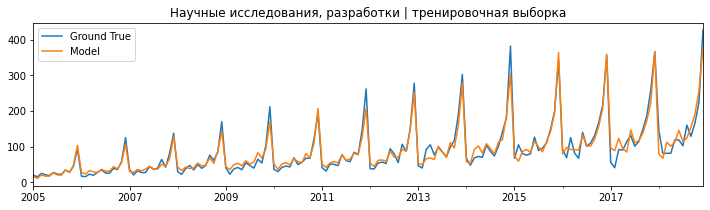

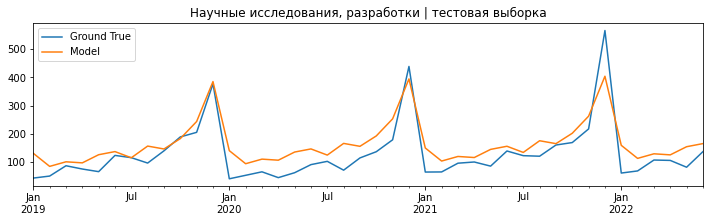

In [47]:
show_results_graph(train, exp_pred_train, test, exp_pred, 'Научные исследования, разработки')

## Обучение моделей

Фичами у нас будут: год, месяц, линейный тренд, стандартное отклонение сезонности в год.

lag применять не имеет смысла, так как будет необходимо сделать долгосрочный прогноз (3 года).

Фичи сгенерируем на период до 2025 года, пригодится для последующего предсказания. Стандартное отклонение для будущих годов будем предсказывать с помощью линейной модели.

Позднее разделим фичи для гибридной модели. Линейная для тренда + LGBMRegressor для растущей сезонности.

In [48]:
y = df.copy()
y_full = pd.concat([y, pd.DataFrame(np.NaN, columns=y.columns, index=pd.date_range(start='2022-07-01', end='2025-12-31', freq='M'))])


X_full = pd.DataFrame(index=pd.date_range(start='2005-01-01', end='2025-12-31', freq='M'))
X_full['year'] = X_full.index.year
X_full['month'] = X_full.index.month
X_full['trend'] = range(1, len(X_full) + 1)

Теперь подсчитаем стандартное отклонение по годам для каждой области.

In [49]:
for column in df.columns:
    decomposition = seasonal_decompose(df[column], model='additive', period=12)
    if column == 'Всего':
        prog_seas = pd.DataFrame(decomposition.seasonal + decomposition.resid, columns=[column])
    else: 
        prog_seas = prog_seas.join(pd.DataFrame(decomposition.seasonal + decomposition.resid, columns=[column]))

prog_seas = prog_seas.groupby(prog_seas.index.year).std()
prog_seas = pd.concat([prog_seas, pd.DataFrame(np.NaN, index=[2023, 2024, 2025], columns=prog_seas.columns)])
prog_seas = prog_seas.reset_index().rename(columns={'index':'year'})
prog_seas.tail()

year        Всего  Рыболовство, рыбоводство  Добыча полезных ископаемых  \
16  2021  2070.347111                   8.64189                   65.875797   
17  2022          NaN                       NaN                         NaN   
18  2023          NaN                       NaN                         NaN   
19  2024          NaN                       NaN                         NaN   
20  2025          NaN                       NaN                         NaN   

    Обрабатывающие производства  Производство кокса, нефтепродуктов  \
16                   602.639147                           71.406879   
17                          NaN                                 NaN   
18                          NaN                                 NaN   
19                          NaN                                 NaN   
20                          NaN                                 NaN   

    Производство резиновых, пластмассовых изделий  \
16                                      14.650039   
17                                            NaN   
18                                            NaN   
19                                            NaN   
20                                            NaN   

    Производство, передача, распределение электроэнергии  \
16                                          76.578966      
17                                                NaN      
18                                                NaN      
19                                                NaN      
20                                                NaN      

    Производство, распределение газообразного топлива  Строительство  \
16                                          54.707755     230.232218   
17                                                NaN            NaN   
18                                                NaN            NaN   
19                                                NaN            NaN   
20                                                NaN            NaN   

    Деятельность воздушного, космического транспорта  \
16                                         20.764341   
17                                               NaN   
18                                               NaN   
19                                               NaN   
20                                               NaN   

    Научные исследования, разработки  Образование  
16                        130.612607    12.314617  
17                               NaN          NaN  
18                               NaN          NaN  
19                               NaN          NaN  
20                               NaN          NaN

И спрогнозируем значения до 2025 года.

In [50]:
X_seas_train, X_seas_pred, y_seas_train, _ = train_test_split(prog_seas[['year']], prog_seas.drop('year', axis=1), test_size=4, shuffle=False)
seas_lin = LinearRegression()
seas_lin.fit(X_seas_train, y_seas_train)
prog_seas.iloc[-4 :, 1 :] = seas_lin.predict(X_seas_pred)
prog_seas.tail()

year        Всего  Рыболовство, рыбоводство  Добыча полезных ископаемых  \
16  2021  2070.347111                  8.641890                   65.875797   
17  2022  1829.982134                  5.938208                  102.376107   
18  2023  1932.077644                  6.220065                  107.075584   
19  2024  2034.173155                  6.501923                  111.775060   
20  2025  2136.268665                  6.783781                  116.474536   

    Обрабатывающие производства  Производство кокса, нефтепродуктов  \
16                   602.639147                           71.406879   
17                   529.256950                          109.477970   
18                   559.318301                          115.515735   
19                   589.379652                          121.553501   
20                   619.441003                          127.591266   

    Производство резиновых, пластмассовых изделий  \
16                                      14.650039   
17                                      13.306455   
18                                      13.979103   
19                                      14.651751   
20                                      15.324399   

    Производство, передача, распределение электроэнергии  \
16                                          76.578966      
17                                          81.389927      
18                                          84.858702      
19                                          88.327477      
20                                          91.796251      

    Производство, распределение газообразного топлива  Строительство  \
16                                          54.707755     230.232218   
17                                          58.337684     184.510937   
18                                          61.460964     193.830321   
19                                          64.584244     203.149706   
20                                          67.707524     212.469090   

    Деятельность воздушного, космического транспорта  \
16                                         20.764341   
17                                         23.832145   
18                                         25.119439   
19                                         26.406733   
20                                         27.694027   

    Научные исследования, разработки  Образование  
16                        130.612607    12.314617  
17                        121.893792    16.709228  
18                        127.748279    17.566637  
19                        133.602767    18.424047  
20                        139.457254    19.281457

In [51]:
X_full = X_full.merge(prog_seas, on='year')
X_full.index = pd.date_range(start='2005-01-01', end='2025-12-31', freq='M')
X = X_full.loc[:'2022-06-30']
X_forecast = X_full.loc['2022-07-01':]

Итого таблица признаков выглядит так:

In [52]:
X.head()

year  month  trend       Всего  Рыболовство, рыбоводство  \
2005-01-31  2005      1      1  191.898771                  0.298518   
2005-02-28  2005      2      2  191.898771                  0.298518   
2005-03-31  2005      3      3  191.898771                  0.298518   
2005-04-30  2005      4      4  191.898771                  0.298518   
2005-05-31  2005      5      5  191.898771                  0.298518   

            Добыча полезных ископаемых  Обрабатывающие производства  \
2005-01-31                   19.441396                     29.91098   
2005-02-28                   19.441396                     29.91098   
2005-03-31                   19.441396                     29.91098   
2005-04-30                   19.441396                     29.91098   
2005-05-31                   19.441396                     29.91098   

            Производство кокса, нефтепродуктов  \
2005-01-31                           14.648935   
2005-02-28                           14.648935   
2005-03-31                           14.648935   
2005-04-30                           14.648935   
2005-05-31                           14.648935   

            Производство резиновых, пластмассовых изделий  \
2005-01-31                                       1.178766   
2005-02-28                                       1.178766   
2005-03-31                                       1.178766   
2005-04-30                                       1.178766   
2005-05-31                                       1.178766   

            Производство, передача, распределение электроэнергии  \
2005-01-31                                          19.280469      
2005-02-28                                          19.280469      
2005-03-31                                          19.280469      
2005-04-30                                          19.280469      
2005-05-31                                          19.280469      

            Производство, распределение газообразного топлива  Строительство  \
2005-01-31                                           3.268405      11.550598   
2005-02-28                                           3.268405      11.550598   
2005-03-31                                           3.268405      11.550598   
2005-04-30                                           3.268405      11.550598   
2005-05-31                                           3.268405      11.550598   

            Деятельность воздушного, космического транспорта  \
2005-01-31                                           1.78032   
2005-02-28                                           1.78032   
2005-03-31                                           1.78032   
2005-04-30                                           1.78032   
2005-05-31                                           1.78032   

            Научные исследования, разработки  Образование  
2005-01-31                         26.879473     2.053563  
2005-02-28                         26.879473     2.053563  
2005-03-31                         26.879473     2.053563  
2005-04-30                         26.879473     2.053563  
2005-05-31                         26.879473     2.053563

Для начала проверим как справляются модели по отдельности.

### Линейная модель без учета стандартного отклонения

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [54]:
def linear(X_train, X_test, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model.predict(X_train), model.predict(X_test)

In [55]:
linear_train, linear_test = linear(X_train.iloc[:,:3], X_test.iloc[:,:3], y_train)

In [56]:
linear_train = pd.DataFrame(linear_train, columns=y_train.columns, index=y_train.index)
linear_test = pd.DataFrame(linear_test, columns=y_test.columns, index=y_test.index)

In [57]:
total_results = total_results.join(results_to_table(y_train, linear_train, 'linear_train'))
total_results = total_results.join(results_to_table(y_test, linear_test, 'linear_test'))

In [58]:
total_results.head()

dummy_lag_test  smoothing_train  \
Всего                    R2          0.588444         0.993955   
                         MAE      1748.130853       208.759729   
                         MAPE        0.090293         0.027114   
Рыболовство, рыбоводство R2          0.314326         0.905267   
                         MAE         6.983186         1.633921   

                               smoothing_test  linear_train  linear_test  
Всего                    R2          0.394007      0.955180    -0.263429  
                         MAE      2245.090986    612.315741  3364.053287  
                         MAPE        0.105312      0.082062     0.153541  
Рыболовство, рыбоводство R2          0.237672      0.746027    -0.364676  
                         MAE         6.678237      3.003233     9.203501

Посмотрим на графическое отображение того как справилась линейная модель.

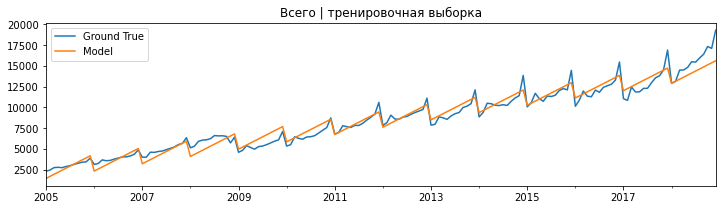

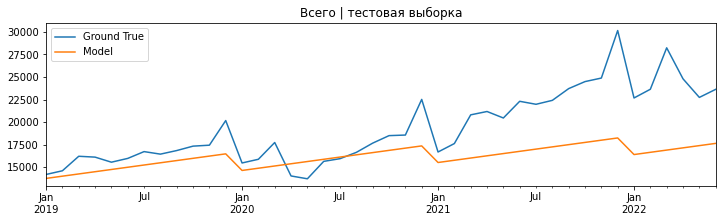

In [59]:
show_results_graph(y_train, linear_train, y_test, linear_test, 'Всего')

Видно, что линейная модель слабо учла сезонность, и довольно сносно отразила тренд на тестовой выборке.

В районе 2022 года наблюдается значительный рост тренда, который раньше в истории измерения оборота не встречался. Именно он снижает точность предказания на тестовой выборке. Это довольно неожиданно, так как я думал, что основным источником неточности будет падение оборота в 2020-2021, а оказалось, что это рост оборота в 2022.

### Линейная модель с учетом стандартного отклонения

Для совершения предсказаний потребуется разбить таблицы признаков по категориям оборота.

In [60]:
linear_train_std = {}
linear_test_std = {}
for column in X.columns[3:]:
    X_train_column = X_train.loc[:,['year', 'month', 'trend', column]]
    X_test_column = X_test.loc[:,['year', 'month', 'trend', column]]
    y_train_column = y_train.loc[:, column]
    linear_train_std[column], linear_test_std[column] = linear(X_train_column, X_test_column, y_train_column)

In [61]:
linear_train_std = pd.DataFrame(linear_train_std, index=y_train.index)
linear_test_std = pd.DataFrame(linear_test_std, index=y_test.index)

In [62]:
total_results = total_results.join(results_to_table(y_train, linear_train_std, 'linear_train_std'))
total_results = total_results.join(results_to_table(y_test, linear_test_std, 'linear_test_std'))

In [63]:
total_results.head()

dummy_lag_test  smoothing_train  \
Всего                    R2          0.588444         0.993955   
                         MAE      1748.130853       208.759729   
                         MAPE        0.090293         0.027114   
Рыболовство, рыбоводство R2          0.314326         0.905267   
                         MAE         6.983186         1.633921   

                               smoothing_test  linear_train  linear_test  \
Всего                    R2          0.394007      0.955180    -0.263429   
                         MAE      2245.090986    612.315741  3364.053287   
                         MAPE        0.105312      0.082062     0.153541   
Рыболовство, рыбоводство R2          0.237672      0.746027    -0.364676   
                         MAE         6.678237      3.003233     9.203501   

                               linear_train_std  linear_test_std  
Всего                    R2            0.959031        -1.413179  
                         MAE         575.578477      4958.205545  
                         MAPE          0.078281         0.231173  
Рыболовство, рыбоводство R2            0.781331         0.062650  
                         MAE           2.847846         7.404610

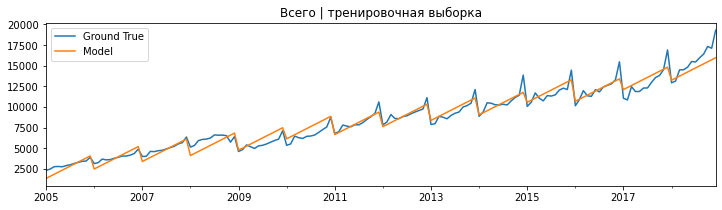

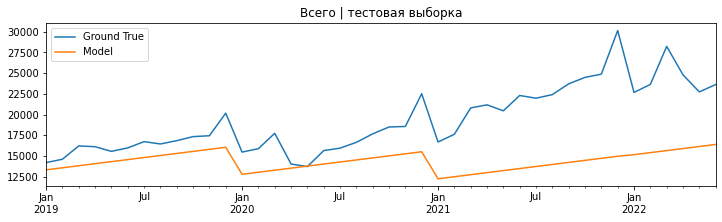

In [64]:
show_results_graph(y_train, linear_train_std, y_test, linear_test_std, 'Всего')

Учет стандартного отклонения для некоторых случаев повысил, а для некоторых понизил точность модели. По графикам однозначно видно, что зубцы отражающие сезонность меняют свою выраженность от года к году. 

### LightGBM без учета стандартного отклонения

In [65]:
def boosting(X_train, X_test, y_train):
    model = LGBMRegressor(random_state=24, linear_tree=True)
    params = dict(max_depth=range(-1, 201), num_leaves=range(5, 101), n_estimators=range(1, 201))
    random_search = RandomizedSearchCV(model, param_distributions=params, scoring='neg_mean_absolute_error', random_state=24, n_iter=100, cv=TimeSeriesSplit())
    random_search.fit(X_train, y_train)
    return random_search.predict(X_train), random_search.predict(X_test), random_search

In [66]:
boosting_train = {}
boosting_test = {}
boosting_models = {}
for column in y.columns:
    boosting_train[column], boosting_test[column], boosting_models[column] = boosting(X_train.iloc[:,:3], X_test.iloc[:,:3], y_train[column])

In [67]:
boosting_train = pd.DataFrame(boosting_train, index=y_train.index)
boosting_test = pd.DataFrame(boosting_test, index=y_test.index)

In [68]:
total_results = total_results.join(results_to_table(y_train, boosting_train, 'boosting_train'))
total_results = total_results.join(results_to_table(y_test, boosting_test, 'boosting_test'))

In [69]:
total_results.head()

dummy_lag_test  smoothing_train  \
Всего                    R2          0.588444         0.993955   
                         MAE      1748.130853       208.759729   
                         MAPE        0.090293         0.027114   
Рыболовство, рыбоводство R2          0.314326         0.905267   
                         MAE         6.983186         1.633921   

                               smoothing_test  linear_train  linear_test  \
Всего                    R2          0.394007      0.955180    -0.263429   
                         MAE      2245.090986    612.315741  3364.053287   
                         MAPE        0.105312      0.082062     0.153541   
Рыболовство, рыбоводство R2          0.237672      0.746027    -0.364676   
                         MAE         6.678237      3.003233     9.203501   

                               linear_train_std  linear_test_std  \
Всего                    R2            0.959031        -1.413179   
                         MAE         575.578477      4958.205545   
                         MAPE          0.078281         0.231173   
Рыболовство, рыбоводство R2            0.781331         0.062650   
                         MAE           2.847846         7.404610   

                               boosting_train  boosting_test  
Всего                    R2          0.990443       0.680572  
                         MAE       278.194783    1674.916375  
                         MAPE        0.033875       0.087608  
Рыболовство, рыбоводство R2          0.956144       0.229085  
                         MAE         1.166852       6.584134

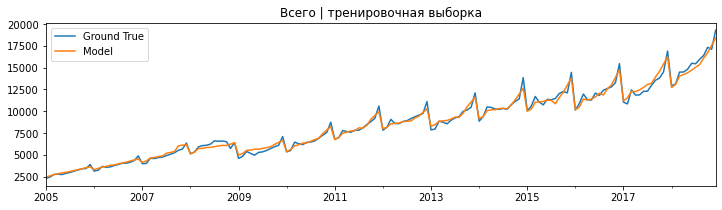

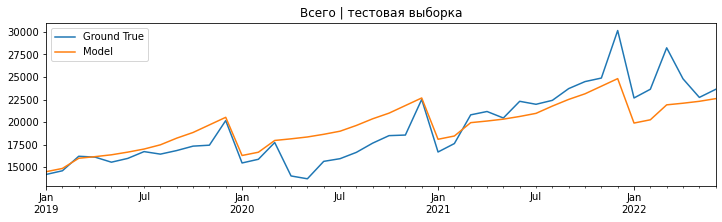

In [70]:
show_results_graph(y_train, boosting_train, y_test, boosting_test, 'Всего')

Бустинг в базовом случае не способен проэкстрополировать рост тренда, но в библиотеке LightGBM у функции LGBMRegressor можно задействовать параметр linear_tree. Этот параметр позоляет учитывать линейный рост тренда.

В целом модель справилась очень хорошо.

### LightGBM с учетом стандартного отклонения

In [71]:
boosting_train_std = {}
boosting_test_std = {}
boosting_models_std = {}
for column in X.columns[3:]:
    X_train_column = X_train.loc[:,['year', 'month', 'trend', column]]
    X_train_column.columns = ['year', 'month', 'trend', 'std'] # LGBMRegressor не поддерживает запятые в названии фичей, пришлось их заменить
    X_test_column = X_test.loc[:,['year', 'month', 'trend', column]]
    X_test_column.columns = ['year', 'month', 'trend', 'std']
    y_train_column = y_train.loc[:, column]
    boosting_train_std[column], boosting_test_std[column], boosting_models_std[column] = boosting(X_train_column, X_test_column, y_train_column)

In [72]:
boosting_train_std = pd.DataFrame(boosting_train_std, index=y_train.index)
boosting_test_std = pd.DataFrame(boosting_test_std, index=y_test.index) 

In [73]:
total_results = total_results.join(results_to_table(y_train, boosting_train_std, 'boosting_train_std'))
total_results = total_results.join(results_to_table(y_test, boosting_test_std, 'boosting_test_std'))

In [74]:
total_results.head()

dummy_lag_test  smoothing_train  \
Всего                    R2          0.588444         0.993955   
                         MAE      1748.130853       208.759729   
                         MAPE        0.090293         0.027114   
Рыболовство, рыбоводство R2          0.314326         0.905267   
                         MAE         6.983186         1.633921   

                               smoothing_test  linear_train  linear_test  \
Всего                    R2          0.394007      0.955180    -0.263429   
                         MAE      2245.090986    612.315741  3364.053287   
                         MAPE        0.105312      0.082062     0.153541   
Рыболовство, рыбоводство R2          0.237672      0.746027    -0.364676   
                         MAE         6.678237      3.003233     9.203501   

                               linear_train_std  linear_test_std  \
Всего                    R2            0.959031        -1.413179   
                         MAE         575.578477      4958.205545   
                         MAPE          0.078281         0.231173   
Рыболовство, рыбоводство R2            0.781331         0.062650   
                         MAE           2.847846         7.404610   

                               boosting_train  boosting_test  \
Всего                    R2          0.990443       0.680572   
                         MAE       278.194783    1674.916375   
                         MAPE        0.033875       0.087608   
Рыболовство, рыбоводство R2          0.956144       0.229085   
                         MAE         1.166852       6.584134   

                               boosting_train_std  boosting_test_std  
Всего                    R2              0.992036         -25.398780  
                         MAE           248.567026       18114.676618  
                         MAPE            0.030813           0.904718  
Рыболовство, рыбоводство R2              0.959842           0.177257  
                         MAE             1.065644           6.813069

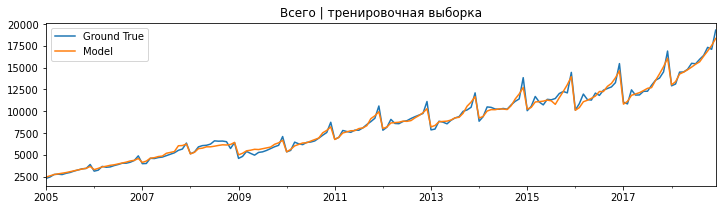

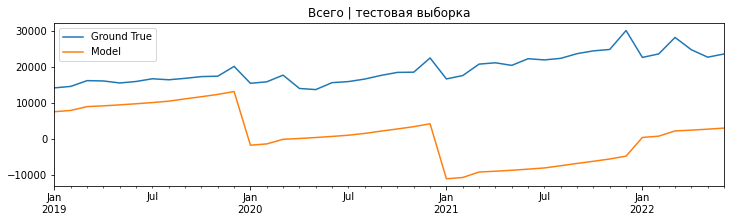

In [75]:
show_results_graph(y_train, boosting_train_std, y_test, boosting_test_std, 'Всего')

Учет стандартного отклонения в общем случае неоднозначно отразился на качестве предсказания. Однако для категории **'Всего'** стандартное отклонение плохо повлияло предсказание тестовой выборки. Скорее всего это связано с допущением о том, что среднее отклонение растет линейно. В некоторых случаях это допущение оказалось верным и улучшило метрики на тестовой выборке, в некоторых - наоборот.

### Гибридная модель без учета стандартного отклонения

In [76]:
X_train_linear = X_train.drop('month', axis=1)
X_train_boosting = X_train[['month']]
X_test_linear = X_test.drop('month', axis=1)
X_test_boosting = X_test[['month']]

In [77]:
linear_train_hybrid, linear_test_hybrid = linear(X_train_linear.iloc[:,:2], X_test_linear.iloc[:,:2], y_train)

In [78]:
linear_train_hybrid = pd.DataFrame(linear_train_hybrid, columns=y_train.columns, index=y_train.index)
linear_test_hybrid = pd.DataFrame(linear_test_hybrid, columns=y_test.columns, index=y_test.index)

In [79]:
y_train_boosting = y_train - linear_train_hybrid

In [80]:
boosting_train_hybrid = {}
boosting_test_hybrid = {}
boosting_models_hybrid = {}
for column in y.columns:
    boosting_train_hybrid[column], boosting_test_hybrid[column], boosting_models_hybrid[column] = boosting(X_train_boosting, X_test_boosting, y_train_boosting[column])

In [81]:
boosting_train_hybrid = pd.DataFrame(boosting_train_hybrid, index=y_train.index)
boosting_test_hybrid = pd.DataFrame(boosting_test_hybrid, index=y_test.index)

hybrid_train = linear_train_hybrid + boosting_train_hybrid
hybrid_test = linear_test_hybrid + boosting_test_hybrid

total_results = total_results.join(results_to_table(y_train, hybrid_train, 'hybrid_train'))
total_results = total_results.join(results_to_table(y_test, hybrid_test, 'hybrid_test'))

In [82]:
total_results.head()

dummy_lag_test  smoothing_train  \
Всего                    R2          0.588444         0.993955   
                         MAE      1748.130853       208.759729   
                         MAPE        0.090293         0.027114   
Рыболовство, рыбоводство R2          0.314326         0.905267   
                         MAE         6.983186         1.633921   

                               smoothing_test  linear_train  linear_test  \
Всего                    R2          0.394007      0.955180    -0.263429   
                         MAE      2245.090986    612.315741  3364.053287   
                         MAPE        0.105312      0.082062     0.153541   
Рыболовство, рыбоводство R2          0.237672      0.746027    -0.364676   
                         MAE         6.678237      3.003233     9.203501   

                               linear_train_std  linear_test_std  \
Всего                    R2            0.959031        -1.413179   
                         MAE         575.578477      4958.205545   
                         MAPE          0.078281         0.231173   
Рыболовство, рыбоводство R2            0.781331         0.062650   
                         MAE           2.847846         7.404610   

                               boosting_train  boosting_test  \
Всего                    R2          0.990443       0.680572   
                         MAE       278.194783    1674.916375   
                         MAPE        0.033875       0.087608   
Рыболовство, рыбоводство R2          0.956144       0.229085   
                         MAE         1.166852       6.584134   

                               boosting_train_std  boosting_test_std  \
Всего                    R2              0.992036         -25.398780   
                         MAE           248.567026       18114.676618   
                         MAPE            0.030813           0.904718   
Рыболовство, рыбоводство R2              0.959842           0.177257   
                         MAE             1.065644           6.813069   

                               hybrid_train  hybrid_test  
Всего                    R2        0.964606    -0.213313  
                         MAE     530.881315  3340.329869  
                         MAPE      0.075574     0.153043  
Рыболовство, рыбоводство R2        0.807302    -0.288250  
                         MAE       2.624835     8.747454

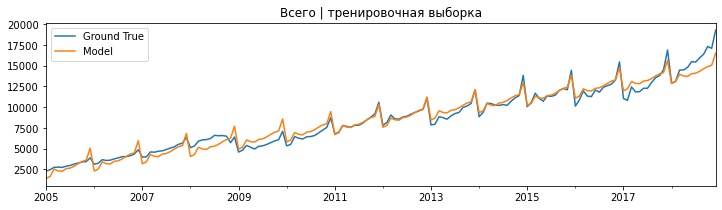

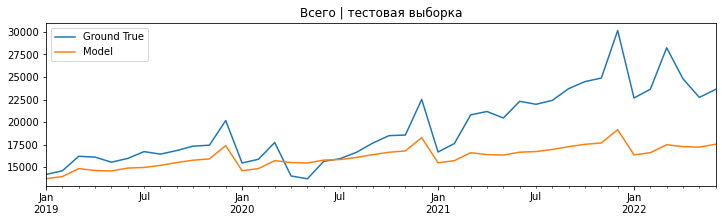

In [83]:
show_results_graph(y_train, hybrid_train, y_test, hybrid_test, 'Всего')

В большинстве случаев гибридная модель показала себя лучше, чем линейная, но хуже чем чистый LGBMRegressor учитывающий линейность.

### Гибридная модель c учетом стандартного отклонения

In [84]:
linear_train_hybrid_std = {}
linear_test_hybrid_std = {}
for column in y.columns:
    X_train_column = X_train.loc[:,['year', 'trend', column]]
    X_test_column = X_test.loc[:,['year', 'trend', column]]
    y_train_column = y_train.loc[:, column]
    linear_train_hybrid_std[column], linear_test_hybrid_std[column] = linear(X_train_column, X_test_column, y_train_column)

In [85]:
linear_train_hybrid_std = pd.DataFrame(linear_train_hybrid_std, index=y_train.index)
linear_test_hybrid_std = pd.DataFrame(linear_test_hybrid_std, index=y_test.index)

In [86]:
y_train_boosting_std = y_train - linear_train_hybrid_std

In [87]:
boosting_train_hybrid_std = {}
boosting_test_hybrid_std = {}
boosting_models_hybrid_std = {}
for column in y.columns:
    boosting_train_hybrid_std[column], boosting_test_hybrid_std[column], boosting_models_hybrid_std[column] = boosting(X_train_boosting, X_test_boosting, y_train_boosting_std[column])

In [88]:
boosting_train_hybrid_std = pd.DataFrame(boosting_train_hybrid_std, index=y_train.index)
boosting_test_hybrid_std = pd.DataFrame(boosting_test_hybrid_std, index=y_test.index)

hybrid_train_std = linear_train_hybrid_std + boosting_train_hybrid_std
hybrid_test_std = linear_test_hybrid_std + boosting_test_hybrid_std

total_results = total_results.join(results_to_table(y_train, hybrid_train_std, 'hybrid_train_std'))
total_results = total_results.join(results_to_table(y_test, hybrid_test_std, 'hybrid_test_std'))

In [89]:
total_results.head()

dummy_lag_test  smoothing_train  \
Всего                    R2          0.588444         0.993955   
                         MAE      1748.130853       208.759729   
                         MAPE        0.090293         0.027114   
Рыболовство, рыбоводство R2          0.314326         0.905267   
                         MAE         6.983186         1.633921   

                               smoothing_test  linear_train  linear_test  \
Всего                    R2          0.394007      0.955180    -0.263429   
                         MAE      2245.090986    612.315741  3364.053287   
                         MAPE        0.105312      0.082062     0.153541   
Рыболовство, рыбоводство R2          0.237672      0.746027    -0.364676   
                         MAE         6.678237      3.003233     9.203501   

                               linear_train_std  linear_test_std  \
Всего                    R2            0.959031        -1.413179   
                         MAE         575.578477      4958.205545   
                         MAPE          0.078281         0.231173   
Рыболовство, рыбоводство R2            0.781331         0.062650   
                         MAE           2.847846         7.404610   

                               boosting_train  boosting_test  \
Всего                    R2          0.990443       0.680572   
                         MAE       278.194783    1674.916375   
                         MAPE        0.033875       0.087608   
Рыболовство, рыбоводство R2          0.956144       0.229085   
                         MAE         1.166852       6.584134   

                               boosting_train_std  boosting_test_std  \
Всего                    R2              0.992036         -25.398780   
                         MAE           248.567026       18114.676618   
                         MAPE            0.030813           0.904718   
Рыболовство, рыбоводство R2              0.959842           0.177257   
                         MAE             1.065644           6.813069   

                               hybrid_train  hybrid_test  hybrid_train_std  \
Всего                    R2        0.964606    -0.213313          0.967901   
                         MAE     530.881315  3340.329869        517.064362   
                         MAPE      0.075574     0.153043          0.073063   
Рыболовство, рыбоводство R2        0.807302    -0.288250          0.842338   
                         MAE       2.624835     8.747454          2.336578   

                               hybrid_test_std  
Всего                    R2          -1.372532  
                         MAE       4948.170720  
                         MAPE         0.231290  
Рыболовство, рыбоводство R2           0.139780  
                         MAE          7.104538

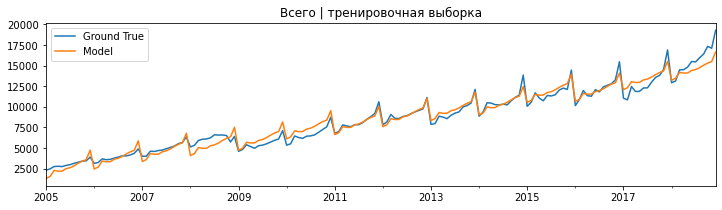

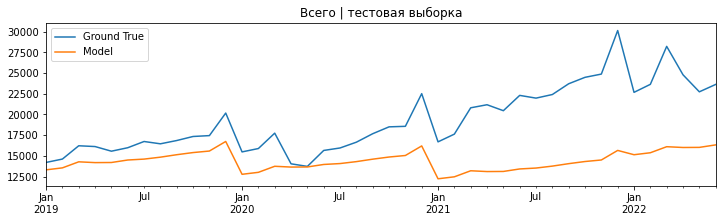

In [90]:
show_results_graph(y_train, hybrid_train_std, y_test, hybrid_test_std, 'Всего')

На гибридную модель учет роста стандартного отклонения повлиял так же неоднозначно, как и на чистый LGBMRegressor.

## Результаты

In [91]:
total_results

dummy_lag_test  \
Всего                                              R2          0.588444   
                                                   MAE      1748.130853   
                                                   MAPE        0.090293   
Рыболовство, рыбоводство                           R2          0.314326   
                                                   MAE         6.983186   
                                                   MAPE        0.199669   
Добыча полезных ископаемых                         R2          0.824642   
                                                   MAE       134.310866   
                                                   MAPE        0.073339   
Обрабатывающие производства                        R2          0.493311   
                                                   MAE       481.656858   
                                                   MAPE        0.108130   
Производство кокса, нефтепродуктов                 R2          0.781047   
                                                   MAE        90.332164   
                                                   MAPE        0.082612   
Производство резиновых, пластмассовых изделий      R2          0.793346   
                                                   MAE        11.295252   
                                                   MAPE        0.095471   
Производство, передача, распределение электроэн... R2          0.724356   
                                                   MAE        36.795321   
                                                   MAPE        0.057327   
Производство, распределение газообразного топлива  R2          0.708320   
                                                   MAE        20.982190   
                                                   MAPE        0.180105   
Строительство                                      R2         -0.217748   
                                                   MAE       139.804425   
                                                   MAPE        0.222629   
Деятельность воздушного, космического транспорта   R2          0.784278   
                                                   MAE        12.296243   
                                                   MAPE        0.127983   
Научные исследования, разработки                   R2         -0.995497   
                                                   MAE        76.717514   
                                                   MAPE        0.960258   
Образование                                        R2          0.026415   
                                                   MAE         9.558084   
                                                   MAPE        0.187999   

                                                         smoothing_train  \
Всего                                              R2           0.993955   
                                                   MAE        208.759729   
                                                   MAPE         0.027114   
Рыболовство, рыбоводство                           R2           0.905267   
                                                   MAE          1.633921   
                                                   MAPE         0.144776   
Добыча полезных ископаемых                         R2           0.983176   
                                                   MAE         34.259027   
                                                   MAPE         0.055983   
Обрабатывающие производства                        R2           0.988721   
                                                   MAE         71.868565   
                                                   MAPE         0.037636   
Производство кокса, нефтепродуктов                 R2           0.966114   
                                                   MAE         35.721415   
                                                   MAPE         0.076680   
Производство резиновых, пластмассовых изделий      R2           0

In [92]:
total_test = total_results[['smoothing_test', 'linear_test', 'linear_test_std', 'boosting_test', 'boosting_test_std', 'hybrid_test', 'hybrid_test_std']]
best_MAE = total_test.loc[(slice(None) ,'MAE'),:]
best_models = best_MAE.idxmin(axis=1)
best_models.index = best_models.index.droplevel(1)
best_models

Всего                                                       boosting_test
Рыболовство, рыбоводство                                    boosting_test
Добыча полезных ископаемых                                 smoothing_test
Обрабатывающие производства                                 boosting_test
Производство кокса, нефтепродуктов                            hybrid_test
Производство резиновых, пластмассовых изделий              smoothing_test
Производство, передача, распределение электроэнергии        boosting_test
Производство, распределение газообразного топлива       boosting_test_std
Строительство                                               boosting_test
Деятельность воздушного, космического транспорта          hybrid_test_std
Научные исследования, разработки                            boosting_test
Образование                                               hybrid_test_std
dtype: object

Даже лучшие модели для наименований:
- Добыча полезных ископаемых, 
- Обрабатывающие производства, 
- Производство кокса, нефтепродуктов, 
- Производство резиновых, пластмассовых изделий 
- Деятельность воздушного, космического транспорта

Не смогли превзойти dummy модель. Видимо именно эти наименования претерпели наибольшие изменения в обороте в течение 2020 - 2022 года.
Значит для них попытаемся предсказать с помощью следующей по метрике модели после dummy модели.

# Предсказание

Для расчета 80% доверительного интервала воспользуемся следующей логикой:

Предположим, что на тренировочной выборке модель совершает такие же ошибки, что и на предсказании. Тогда крайние значения 80%-ного доверительного интервала будут 10-ый и 90-ый перцентили от распределения ошибки предсказания на тренировочной выборке. Для использования на этапе предсказания сохраним эти значения для каждого наименования в словарь.

## С помощью LGBMRegressor

In [93]:
best_boosting = best_models[best_models == 'boosting_test']
best_boosting = list(best_boosting.index)
best_boosting

['Всего',
 'Рыболовство, рыбоводство',
 'Обрабатывающие производства',
 'Производство, передача, распределение электроэнергии',
 'Строительство',
 'Научные исследования, разработки']

In [94]:
y_forecast = {}
interval = {}
for column in best_boosting:
    model = boosting_models[column].best_estimator_
    model.fit(X.iloc[:, :3], y[column])
    y_forecast[column] = model.predict(X_forecast.iloc[:, :3])
    
    y_train_pred = y[column] - model.predict(X.iloc[:, :3])
    interval[column] = y_train_pred.quantile(0.1) - y_train_pred.mean(), y_train_pred.quantile(0.9) - y_train_pred.mean()

## С помощью сглаживания

In [95]:
best_smoothing = best_models[best_models == 'smoothing_test']
best_smoothing = list(best_smoothing.index)
best_smoothing

['Добыча полезных ископаемых', 'Производство резиновых, пластмассовых изделий']

In [96]:
for column in best_smoothing:
    exp_smoothing = ExponentialSmoothing(y[column], trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True, method='least_squares')
    y_forecast[column] = exp_smoothing.forecast(len(X_forecast))
    
    y_train_pred = y[column] - exp_smoothing.fittedvalues
    interval[column] = y_train_pred.quantile(0.1) - y_train_pred.mean(), y_train_pred.quantile(0.9) - y_train_pred.mean()

## С помощью гибридной модели

In [97]:
best_hybrid = best_models[best_models == 'hybrid_test']
best_hybrid = list(best_hybrid.index)
best_hybrid

['Производство кокса, нефтепродуктов']

In [98]:
for column in best_hybrid:
    y_linear_train, y_linear_forecast = linear(X[['year', 'trend']], X_forecast[['year', 'trend']], y[column])
    y_boostring_train = y[column] - y_linear_train
    model = boosting_models_hybrid[column].best_estimator_
    model.fit(X[['month']], y[column])
    y_boosting_forecast =  model.predict(X_forecast[['month']])
    
    y_forecast[column] = y_linear_forecast + y_boosting_forecast
    
    y_train_pred = y[column] - (y_linear_train + model.predict(X[['month']]))
    interval[column] = y_train_pred.quantile(0.1) - y_train_pred.mean(), y_train_pred.quantile(0.9) - y_train_pred.mean()

## С помощью LGBMRegressor c учетом стандартного отклонения

In [99]:
best_boosting_std = best_models[best_models == 'boosting_test_std']
best_boosting_std = list(best_boosting_std.index)
best_boosting_std

['Производство, распределение газообразного топлива']

In [100]:
for column in best_boosting_std:
    X_boosting_std = X[['year', 'month', 'trend', column]]
    X_boosting_std.columns = ['year', 'month', 'trend', 'std']
    X_boosting_forecast_std = X_forecast[['year', 'month', 'trend', column]]
    X_boosting_forecast_std.columns = ['year', 'month', 'trend', 'std']
    
    model = boosting_models_std[column].best_estimator_
    model.fit(X_boosting_std, y[column])
    y_forecast[column] = model.predict(X_boosting_forecast_std)
    
    y_train_pred = y[column] - model.predict(X_boosting_std)
    interval[column] = y_train_pred.quantile(0.1) - y_train_pred.mean(), y_train_pred.quantile(0.9) - y_train_pred.mean()

## С помощью гибридной модели c учетом стандартного отклонения

In [101]:
best_hybrid_std = best_models[best_models == 'hybrid_test_std']
best_hybrid_std = list(best_hybrid_std.index)
best_hybrid_std

['Деятельность воздушного, космического транспорта', 'Образование']

In [102]:
for column in best_hybrid_std:
    y_linear_train, y_linear_forecast = linear(X[['year', 'trend', column]], X_forecast[['year', 'trend', column]], y[column])
    y_boostring_train = y[column] - y_linear_train
    model = boosting_models_hybrid_std[column].best_estimator_
    model.fit(X[['month']], y[column])
    y_boosting_forecast =  model.predict(X_forecast[['month']])
    
    y_forecast[column] = y_linear_forecast + y_boosting_forecast
    
    y_train_pred = y[column] - (y_linear_train + model.predict(X[['month']]))
    interval[column] = y_train_pred.quantile(0.1) - y_train_pred.mean(), y_train_pred.quantile(0.9) - y_train_pred.mean()

## Результат

In [103]:
y_forecast = pd.DataFrame(y_forecast, index=X_forecast.index)

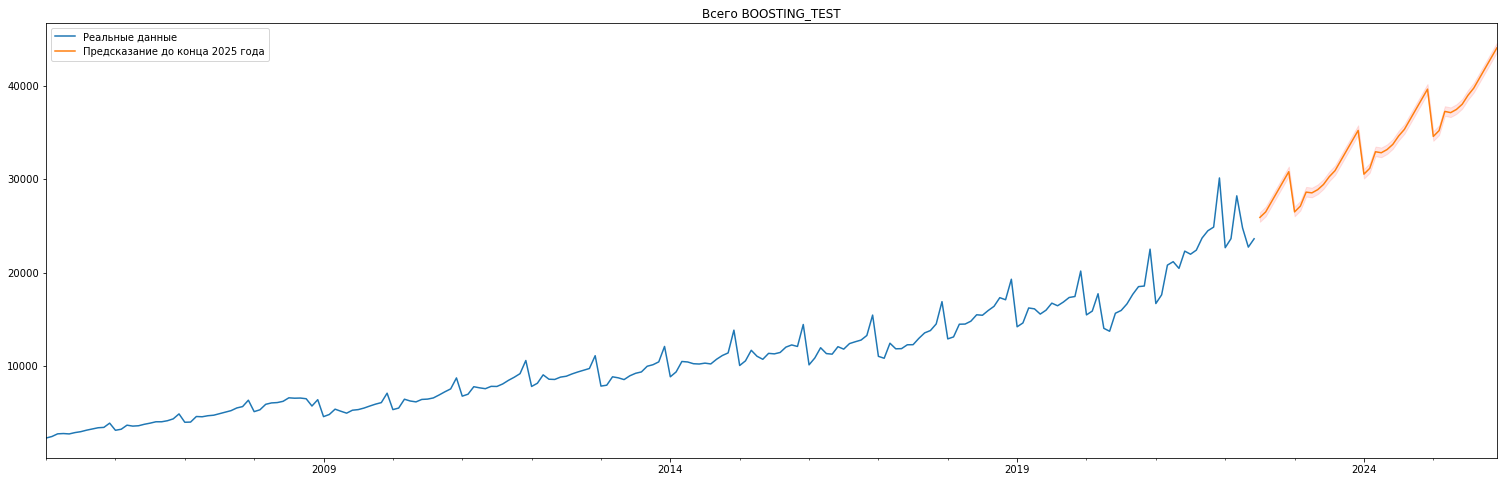

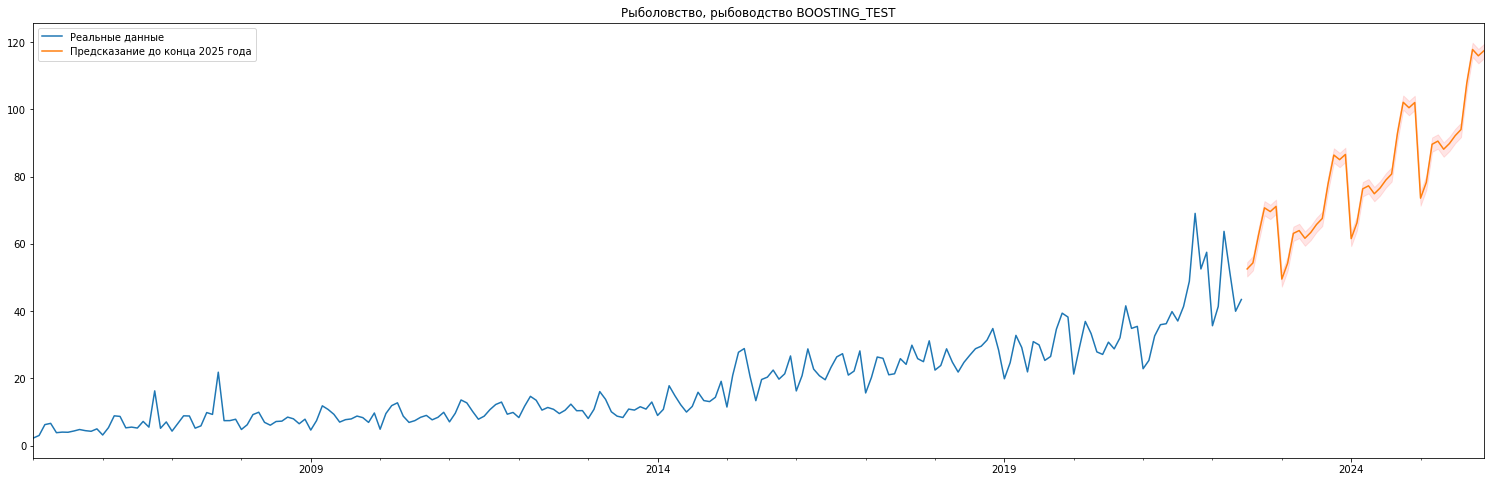

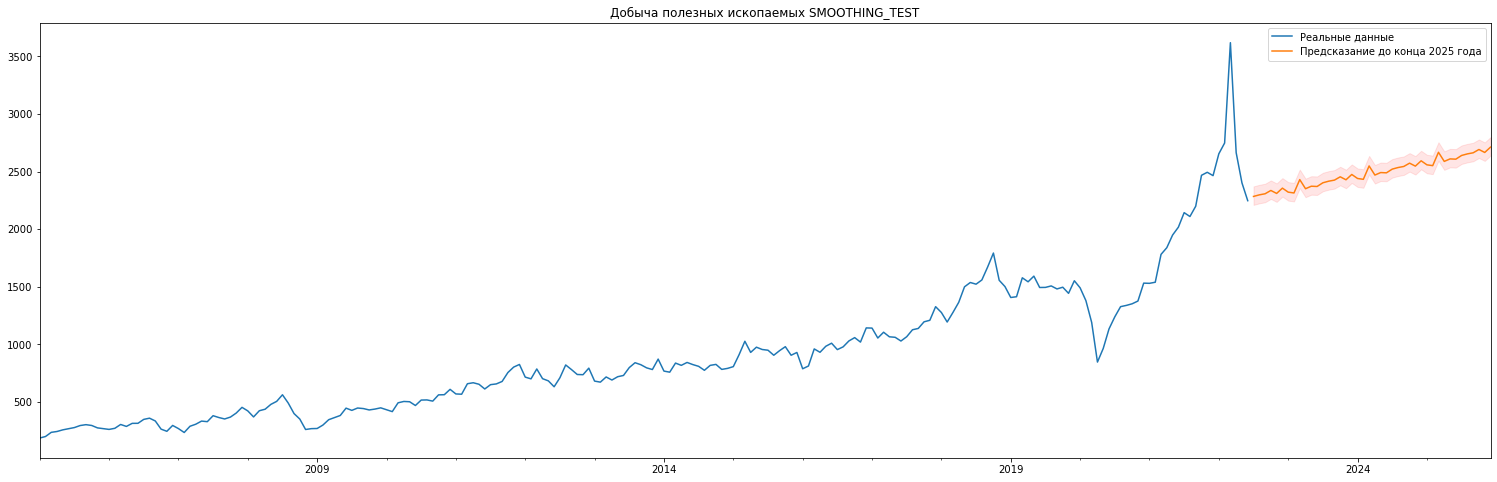

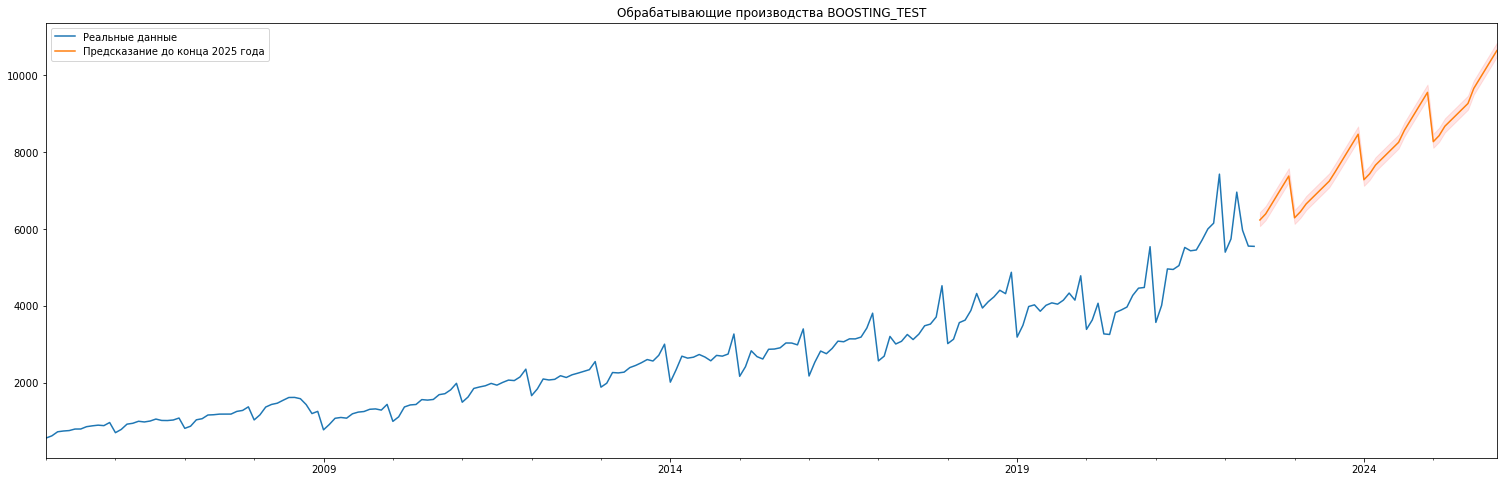

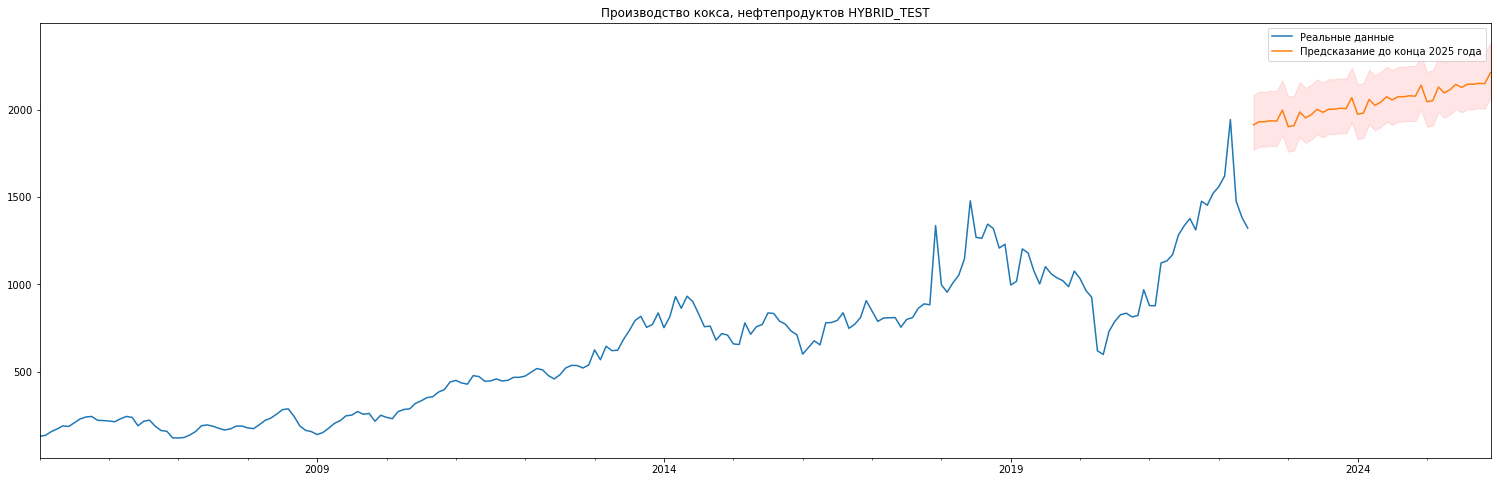

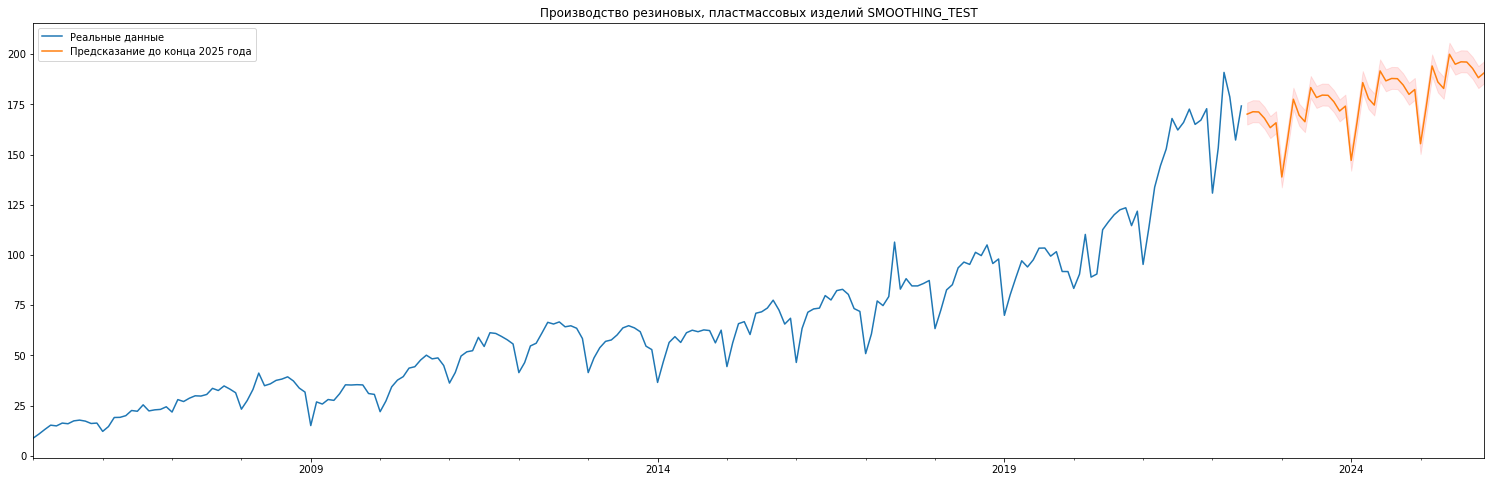

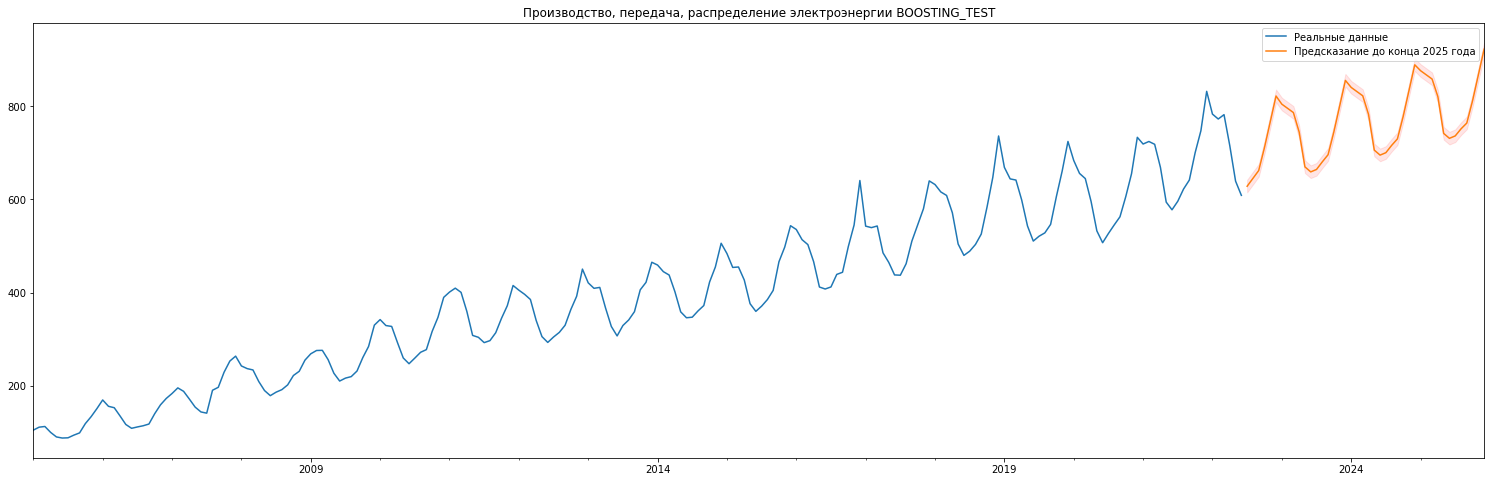

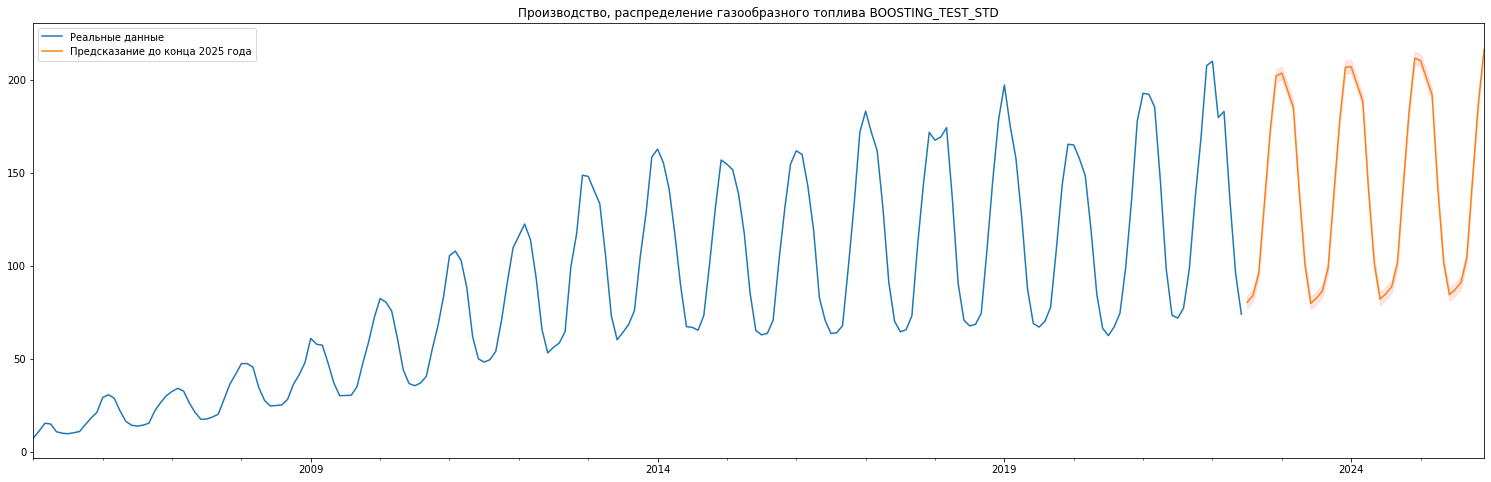

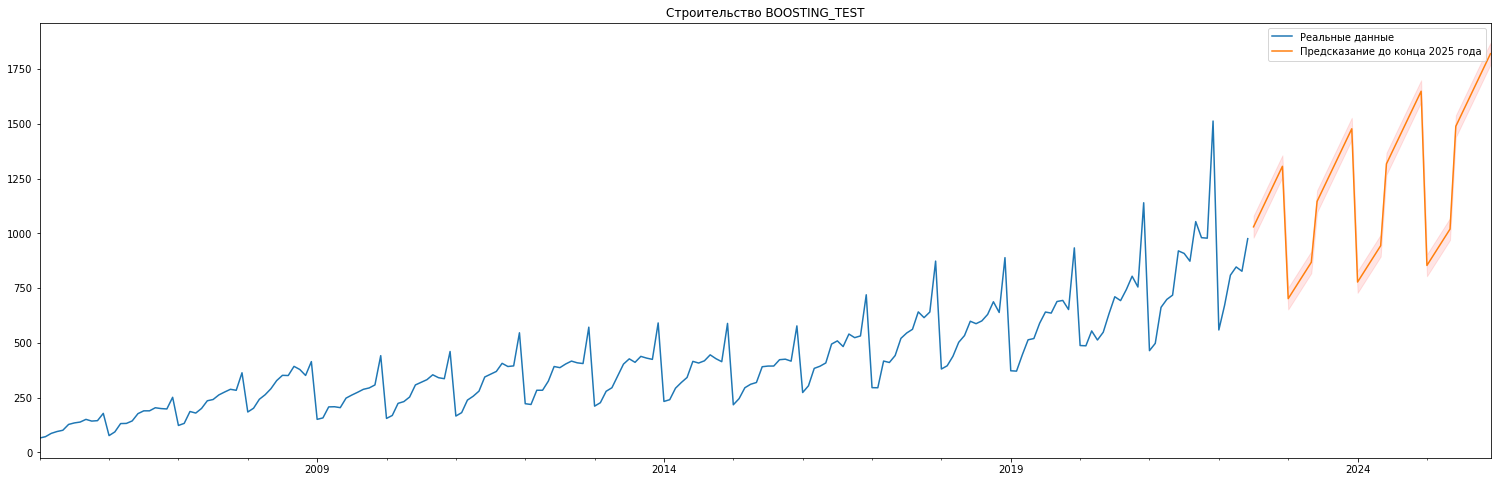

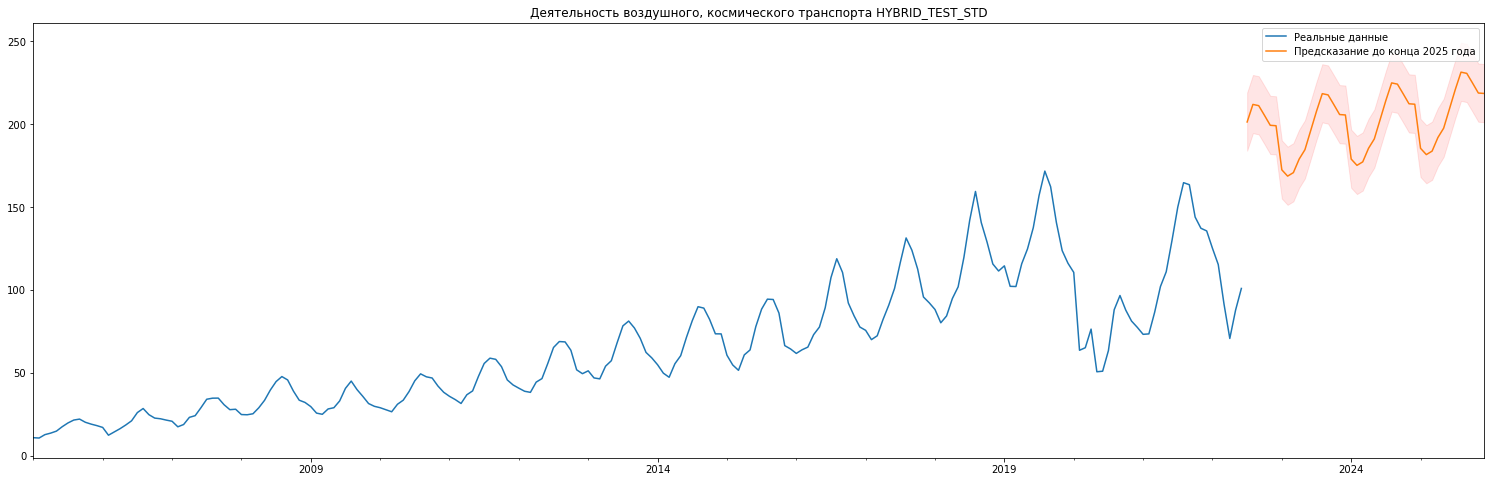

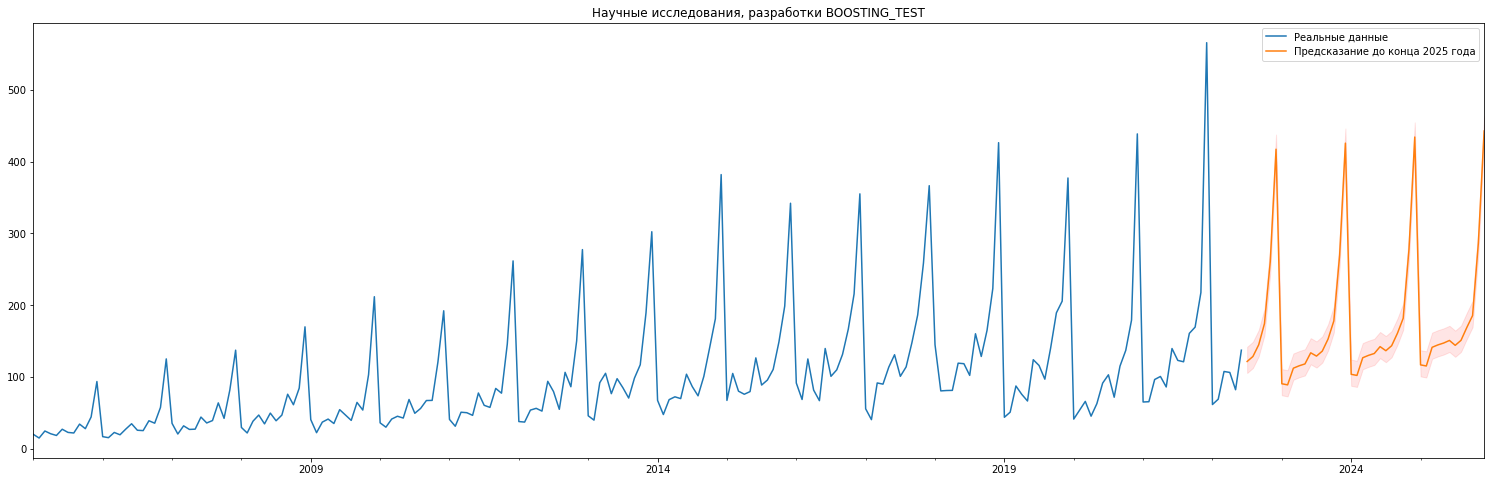

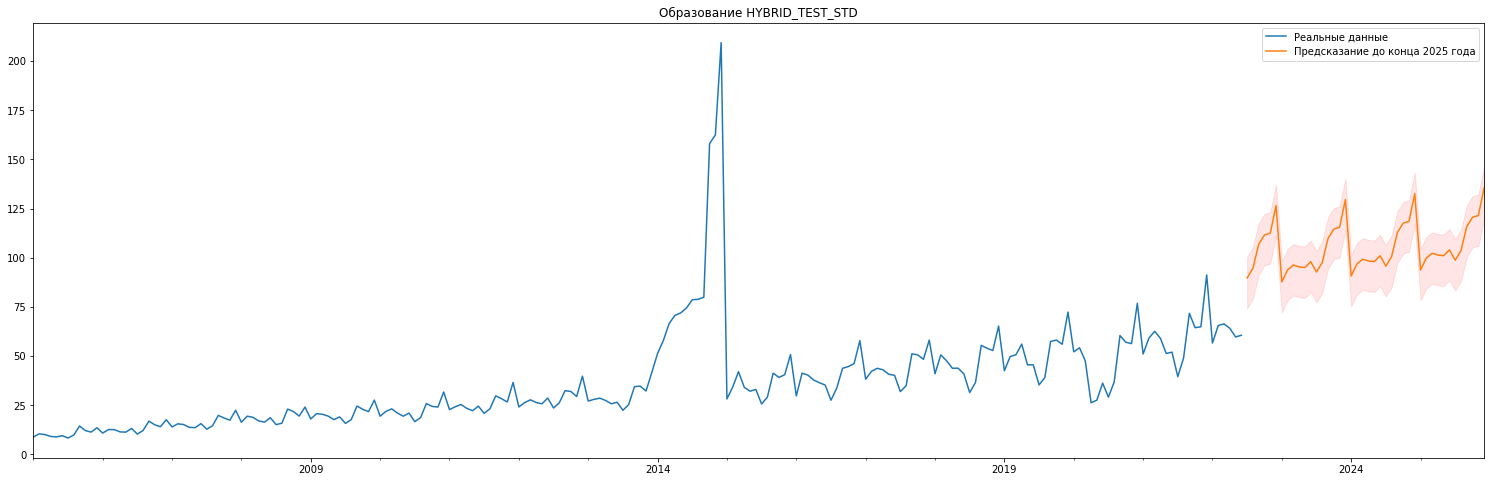

In [104]:
for column in y.columns:
    plt.figure(figsize=(26, 8))
    y[column].plot()
    ax = y_forecast[column].plot()
    ax.fill_between(y_forecast.index, (y_forecast[column] + interval[column][0]), (y_forecast[column] + interval[column][1]), color='r', alpha=0.1)
    plt.title(column + ' ' + best_models[column].upper())
    plt.legend(('Реальные данные', 'Предсказание до конца 2025 года'))
    plt.show()

На глаз самыми адекватными выглядят предсказания данные LBGM моделями и экпоненциальным сглаживанием.

Гибридные модели дают предказание с "разрывом" между концом реальных данных и началом предсказания. Это связано с тем, что в основе гибридной модели лежит линейная, отражающая тренд. А тренд, который порядком лихорадило с 2020 до 2022 года дает менший вклад в чем в линейную модель, чем все стабильные годы до того. Так что гибридная модель предсказывает так, как будто больших колебаний 2020-2022 не было вовсе и продолжает тренд более спокойных годов.

**"Образование"** - отельный случай. Огромный пик в 2014 - 2015 году оказал сильное влияние на линейную модель в основе гибридной, что и дало разрыв между реальными данными и предсказанием.